## Loading Data

In [1]:
import os
import ast
import typing
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import date, datetime

pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/nil.gordillo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
os.makedirs('./bicing', exist_ok=True)

if not len(os.listdir('./bicing')):
    i2m = list(zip(range(1,13), months))
    for year in [2023, 2022, 2021, 2020, 2019]:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"mv '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv' './bicing' ")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

--2023-06-29 09:03:58--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_01_Gener_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22666599 (22M) [application/x-7z-compressed]
Saving to: ‘2023_01_Gener_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  840K 26s
    50K .......... .......... .......... .......... ..........  0% 1.06M 23s
   100K .......... .......... .......... .......... ..........  0% 82.1M 16s
   150K .......... .......... .......... .......... ..........  0% 1.10M 16s
   200K .......... .......... .......... .......... ..........  1% 1.11M 17s
   250K .......... .......... .......... .......... ..........  1% 4.17M 15s
   300K .......... .......... .......... ....

  5150K .......... .......... .......... .......... .......... 23% 1.19M 6s
  5200K .......... .......... .......... .......... .......... 23% 5.62M 6s
  5250K .......... .......... .......... .......... .......... 23% 80.3M 6s
  5300K .......... .......... .......... .......... .......... 24% 15.7M 6s
  5350K .......... .......... .......... .......... .......... 24% 15.6M 6s
  5400K .......... .......... .......... .......... .......... 24%  194M 6s
  5450K .......... .......... .......... .......... .......... 24% 10.5M 6s
  5500K .......... .......... .......... .......... .......... 25% 1.90M 6s
  5550K .......... .......... .......... .......... .......... 25% 2.84M 6s
  5600K .......... .......... .......... .......... .......... 25% 23.2M 6s
  5650K .......... .......... .......... .......... .......... 25% 94.1M 6s
  5700K .......... .......... .......... .......... .......... 25% 25.9M 6s
  5750K .......... .......... .......... .......... .......... 26% 45.7M 6s
  5800K ....

 12400K .......... .......... .......... .......... .......... 56%  750K 2s
 12450K .......... .......... .......... .......... .......... 56% 72.9M 2s
 12500K .......... .......... .......... .......... .......... 56%  221M 2s
 12550K .......... .......... .......... .......... .......... 56%  201M 2s
 12600K .......... .......... .......... .......... .......... 57% 4.51M 2s
 12650K .......... .......... .......... .......... .......... 57%  151M 2s
 12700K .......... .......... .......... .......... .......... 57%  156M 2s
 12750K .......... .......... .......... .......... .......... 57% 4.54M 2s
 12800K .......... .......... .......... .......... .......... 58% 95.2M 2s
 12850K .......... .......... .......... .......... .......... 58% 71.1M 2s
 12900K .......... .......... .......... .......... .......... 58% 33.4M 2s
 12950K .......... .......... .......... .......... .......... 58% 14.7M 2s
 13000K .......... .......... .......... .......... .......... 58%  101M 2s
 13050K ....

 20550K .......... .......... .......... .......... .......... 93% 3.83M 0s
 20600K .......... .......... .......... .......... .......... 93%  198M 0s
 20650K .......... .......... .......... .......... .......... 93%  202M 0s
 20700K .......... .......... .......... .......... .......... 93%  110M 0s
 20750K .......... .......... .......... .......... .......... 93% 14.0M 0s
 20800K .......... .......... .......... .......... .......... 94%  276M 0s
 20850K .......... .......... .......... .......... .......... 94%  114M 0s
 20900K .......... .......... .......... .......... .......... 94%  159M 0s
 20950K .......... .......... .......... .......... .......... 94% 15.1M 0s
 21000K .......... .......... .......... .......... .......... 95% 2.89M 0s
 21050K .......... .......... .......... .......... .......... 95% 27.7M 0s
 21100K .......... .......... .......... .......... .......... 95% 46.0M 0s
 21150K .......... .......... .......... .......... .......... 95% 14.2M 0s
 21200K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 22666599 bytes (22 MiB)

Extracting archive: 2023_01_Gener_BicingNou_ESTACIONS.7z
--
Path = 2023_01_Gener_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 22666599
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       265053242
Compressed: 22666599


--2023-06-29 09:04:03--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_02_Febrer_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22816534 (22M) [application/x-7z-compressed]
Saving to: ‘2023_02_Febrer_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1001K 22s
    50K .......... .......... .......... .......... ..........  0% 1.08M 21s
   100K .......... .......... .......... .......... ..........  0% 1.09M 21s
   150K .......... .......... .......... .......... ..........  0%  649K 24s
   200K .......... .......... .......... .......... ..........  1%  893K 24s
   250K .......... .......... .......... .......... ..........  1% 1.12M 23s
   300K .......... .......... .......... ..

  5100K .......... .......... .......... .......... .......... 23%  652K 8s
  5150K .......... .......... .......... .......... .......... 23% 15.8M 7s
  5200K .......... .......... .......... .......... .......... 23% 9.42M 7s
  5250K .......... .......... .......... .......... .......... 23% 40.0M 7s
  5300K .......... .......... .......... .......... .......... 24%  119M 7s
  5350K .......... .......... .......... .......... .......... 24% 1.09M 7s
  5400K .......... .......... .......... .......... .......... 24%  121M 7s
  5450K .......... .......... .......... .......... .......... 24% 20.5M 7s
  5500K .......... .......... .......... .......... .......... 24% 17.2M 7s
  5550K .......... .......... .......... .......... .......... 25%  125M 7s
  5600K .......... .......... .......... .......... .......... 25% 16.6M 7s
  5650K .......... .......... .......... .......... .......... 25% 1.26M 7s
  5700K .......... .......... .......... .......... .......... 25%  142M 7s
  5750K ....

 12150K .......... .......... .......... .......... .......... 54% 1.79M 3s
 12200K .......... .......... .......... .......... .......... 54% 12.9M 3s
 12250K .......... .......... .......... .......... .......... 55% 87.0M 3s
 12300K .......... .......... .......... .......... .......... 55% 17.7M 3s
 12350K .......... .......... .......... .......... .......... 55% 1.10M 3s
 12400K .......... .......... .......... .......... .......... 55% 19.0M 3s
 12450K .......... .......... .......... .......... .......... 56% 99.9M 3s
 12500K .......... .......... .......... .......... .......... 56% 21.0M 2s
 12550K .......... .......... .......... .......... .......... 56% 35.0M 2s
 12600K .......... .......... .......... .......... .......... 56%  182M 2s
 12650K .......... .......... .......... .......... .......... 56% 35.1M 2s
 12700K .......... .......... .......... .......... .......... 57% 60.7M 2s
 12750K .......... .......... .......... .......... .......... 57% 22.0M 2s
 12800K ....

 17900K .......... .......... .......... .......... .......... 80% 32.2M 1s
 17950K .......... .......... .......... .......... .......... 80% 26.9M 1s
 18000K .......... .......... .......... .......... .......... 81% 54.3M 1s
 18050K .......... .......... .......... .......... .......... 81% 26.6M 1s
 18100K .......... .......... .......... .......... .......... 81% 44.9M 1s
 18150K .......... .......... .......... .......... .......... 81% 29.2M 1s
 18200K .......... .......... .......... .......... .......... 81% 60.9M 1s
 18250K .......... .......... .......... .......... .......... 82% 60.0M 1s
 18300K .......... .......... .......... .......... .......... 82% 27.5M 1s
 18350K .......... .......... .......... .......... .......... 82% 37.9M 1s
 18400K .......... .......... .......... .......... .......... 82%  143M 1s
 18450K .......... .......... .......... .......... .......... 83% 30.3M 1s
 18500K .......... .......... .......... .......... .......... 83% 17.5M 1s
 18550K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 22816534 bytes (22 MiB)

Extracting archive: 2023_02_Febrer_BicingNou_ESTACIONS.7z
--
Path = 2023_02_Febrer_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 22816534
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       265138589
Compressed: 22816534


--2023-06-29 09:04:08--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_03_Marc_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24177077 (23M) [application/x-7z-compressed]
Saving to: ‘2023_03_Marc_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.02M 23s
    50K .......... .......... .......... .......... ..........  0%  932K 24s
   100K .......... .......... .......... .......... ..........  0% 1.08M 23s
   150K .......... .......... .......... .......... ..........  0%  976K 23s
   200K .......... .......... .......... .......... ..........  1%  691K 25s
   250K .......... .......... .......... .......... ..........  1% 1.08M 25s
   300K .......... .......... .......... ......

  5050K .......... .......... .......... .......... .......... 21%  866K 8s
  5100K .......... .......... .......... .......... .......... 21% 85.2M 8s
  5150K .......... .......... .......... .......... .......... 22% 13.9M 8s
  5200K .......... .......... .......... .......... .......... 22% 31.9M 8s
  5250K .......... .......... .......... .......... .......... 22% 40.3M 8s
  5300K .......... .......... .......... .......... .......... 22%  139M 8s
  5350K .......... .......... .......... .......... .......... 22% 1.15M 8s
  5400K .......... .......... .......... .......... .......... 23%  156M 8s
  5450K .......... .......... .......... .......... .......... 23% 46.2M 8s
  5500K .......... .......... .......... .......... .......... 23% 44.4M 8s
  5550K .......... .......... .......... .......... .......... 23% 21.5M 8s
  5600K .......... .......... .......... .......... .......... 23% 20.5M 8s
  5650K .......... .......... .......... .......... .......... 24% 1.15M 8s
  5700K ....

 11550K .......... .......... .......... .......... .......... 49% 2.64M 3s
 11600K .......... .......... .......... .......... .......... 49% 52.8M 3s
 11650K .......... .......... .......... .......... .......... 49% 11.0M 3s
 11700K .......... .......... .......... .......... .......... 49%  228M 3s
 11750K .......... .......... .......... .......... .......... 49% 84.3M 3s
 11800K .......... .......... .......... .......... .......... 50% 17.6M 3s
 11850K .......... .......... .......... .......... .......... 50% 8.16M 3s
 11900K .......... .......... .......... .......... .......... 50%  168M 3s
 11950K .......... .......... .......... .......... .......... 50% 3.81M 3s
 12000K .......... .......... .......... .......... .......... 51% 49.5M 3s
 12050K .......... .......... .......... .......... .......... 51%  229M 3s
 12100K .......... .......... .......... .......... .......... 51% 17.7M 3s
 12150K .......... .......... .......... .......... .......... 51% 23.9M 3s
 12200K ....

 16950K .......... .......... .......... .......... .......... 72% 14.1M 1s
 17000K .......... .......... .......... .......... .......... 72% 19.0M 1s
 17050K .......... .......... .......... .......... .......... 72% 10.2M 1s
 17100K .......... .......... .......... .......... .......... 72% 1.98M 1s
 17150K .......... .......... .......... .......... .......... 72% 8.90M 1s
 17200K .......... .......... .......... .......... .......... 73% 48.1M 1s
 17250K .......... .......... .......... .......... .......... 73%  141M 1s
 17300K .......... .......... .......... .......... .......... 73%  102M 1s
 17350K .......... .......... .......... .......... .......... 73%  192M 1s
 17400K .......... .......... .......... .......... .......... 73% 42.2M 1s
 17450K .......... .......... .......... .......... .......... 74% 27.4M 1s
 17500K .......... .......... .......... .......... .......... 74% 25.0M 1s
 17550K .......... .......... .......... .......... .......... 74% 22.8M 1s
 17600K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24177077 bytes (24 MiB)

Extracting archive: 2023_03_Marc_BicingNou_ESTACIONS.7z
--
Path = 2023_03_Marc_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24177077
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       280034612
Compressed: 24177077


--2023-06-29 09:04:14--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_04_Abril_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20467162 (20M) [application/x-7z-compressed]
Saving to: ‘2023_04_Abril_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 18s
    50K .......... .......... .......... .......... ..........  0%  551K 27s
   100K .......... .......... .......... .......... ..........  0% 96.1M 18s
   150K .......... .......... .......... .......... ..........  1%  125M 14s
   200K .......... .......... .......... .......... ..........  1% 1.12M 14s
   250K .......... .......... .......... .......... ..........  1% 39.2M 12s
   300K .......... .......... .......... ....

  5400K .......... .......... .......... .......... .......... 27%  744K 3s
  5450K .......... .......... .......... .......... .......... 27% 20.2M 3s
  5500K .......... .......... .......... .......... .......... 27% 12.5M 3s
  5550K .......... .......... .......... .......... .......... 28% 39.5M 3s
  5600K .......... .......... .......... .......... .......... 28% 20.3M 3s
  5650K .......... .......... .......... .......... .......... 28% 15.2M 3s
  5700K .......... .......... .......... .......... .......... 28%  132M 3s
  5750K .......... .......... .......... .......... .......... 29% 36.4M 3s
  5800K .......... .......... .......... .......... .......... 29% 12.2M 3s
  5850K .......... .......... .......... .......... .......... 29% 1.13M 3s
  5900K .......... .......... .......... .......... .......... 29% 22.2M 3s
  5950K .......... .......... .......... .......... .......... 30% 51.0M 3s
  6000K .......... .......... .......... .......... .......... 30% 14.3M 3s
  6050K ....

 11100K .......... .......... .......... .......... .......... 55%  848K 2s
 11150K .......... .......... .......... .......... .......... 56% 19.0M 2s
 11200K .......... .......... .......... .......... .......... 56% 15.7M 2s
 11250K .......... .......... .......... .......... .......... 56% 13.4M 2s
 11300K .......... .......... .......... .......... .......... 56%  129M 1s
 11350K .......... .......... .......... .......... .......... 57% 9.09M 1s
 11400K .......... .......... .......... .......... .......... 57%  169M 1s
 11450K .......... .......... .......... .......... .......... 57% 16.0M 1s
 11500K .......... .......... .......... .......... .......... 57%  126M 1s
 11550K .......... .......... .......... .......... .......... 58% 21.7M 1s
 11600K .......... .......... .......... .......... .......... 58% 44.7M 1s
 11650K .......... .......... .......... .......... .......... 58% 37.5M 1s
 11700K .......... .......... .......... .......... .......... 58% 20.2M 1s
 11750K ....

 16750K .......... .......... .......... .......... .......... 84% 10.5M 0s
 16800K .......... .......... .......... .......... .......... 84% 21.5M 0s
 16850K .......... .......... .......... .......... .......... 84% 41.3M 0s
 16900K .......... .......... .......... .......... .......... 84% 22.7M 0s
 16950K .......... .......... .......... .......... .......... 85% 49.0M 0s
 17000K .......... .......... .......... .......... .......... 85% 14.8M 0s
 17050K .......... .......... .......... .......... .......... 85% 44.5M 0s
 17100K .......... .......... .......... .......... .......... 85% 13.7M 0s
 17150K .......... .......... .......... .......... .......... 86% 6.16M 0s
 17200K .......... .......... .......... .......... .......... 86% 14.0M 0s
 17250K .......... .......... .......... .......... .......... 86% 59.8M 0s
 17300K .......... .......... .......... .......... .......... 86% 33.5M 0s
 17350K .......... .......... .......... .......... .......... 87% 23.2M 0s
 17400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 20467162 bytes (20 MiB)

Extracting archive: 2023_04_Abril_BicingNou_ESTACIONS.7z
--
Path = 2023_04_Abril_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 20467162
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       235284952
Compressed: 20467162


--2023-06-29 09:04:18--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_05_Maig_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24235825 (23M) [application/x-7z-compressed]
Saving to: ‘2023_05_Maig_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 21s
    50K .......... .......... .......... .......... ..........  0% 1.08M 21s
   100K .......... .......... .......... .......... ..........  0% 53.5M 14s
   150K .......... .......... .......... .......... ..........  0% 8.64M 11s
   200K .......... .......... .......... .......... ..........  1% 1.11M 13s
   250K .......... .......... .......... .......... ..........  1% 17.8M 11s
   300K .......... .......... .......... ......

  5750K .......... .......... .......... .......... .......... 24% 3.39M 2s
  5800K .......... .......... .......... .......... .......... 24% 1.69M 2s
  5850K .......... .......... .......... .......... .......... 24% 89.6M 2s
  5900K .......... .......... .......... .......... .......... 25%  174M 2s
  5950K .......... .......... .......... .......... .......... 25%  127M 2s
  6000K .......... .......... .......... .......... .......... 25%  204M 2s
  6050K .......... .......... .......... .......... .......... 25%  127M 2s
  6100K .......... .......... .......... .......... .......... 25% 22.1M 2s
  6150K .......... .......... .......... .......... .......... 26%  188M 2s
  6200K .......... .......... .......... .......... .......... 26% 17.5M 2s
  6250K .......... .......... .......... .......... .......... 26%  214M 2s
  6300K .......... .......... .......... .......... .......... 26% 51.8M 2s
  6350K .......... .......... .......... .......... .......... 27% 30.1M 2s
  6400K ....

 13250K .......... .......... .......... .......... .......... 56% 16.0M 1s
 13300K .......... .......... .......... .......... .......... 56%  129M 1s
 13350K .......... .......... .......... .......... .......... 56% 31.1M 1s
 13400K .......... .......... .......... .......... .......... 56%  108M 1s
 13450K .......... .......... .......... .......... .......... 57% 23.6M 1s
 13500K .......... .......... .......... .......... .......... 57% 35.5M 1s
 13550K .......... .......... .......... .......... .......... 57% 28.1M 1s
 13600K .......... .......... .......... .......... .......... 57% 19.6M 1s
 13650K .......... .......... .......... .......... .......... 57% 34.6M 1s
 13700K .......... .......... .......... .......... .......... 58% 39.7M 1s
 13750K .......... .......... .......... .......... .......... 58% 18.9M 1s
 13800K .......... .......... .......... .......... .......... 58% 21.2M 1s
 13850K .......... .......... .......... .......... .......... 58% 45.7M 1s
 13900K ....

 19400K .......... .......... .......... .......... .......... 82% 12.0M 0s
 19450K .......... .......... .......... .......... .......... 82% 45.6M 0s
 19500K .......... .......... .......... .......... .......... 82% 15.4M 0s
 19550K .......... .......... .......... .......... .......... 82% 70.0M 0s
 19600K .......... .......... .......... .......... .......... 83% 86.7M 0s
 19650K .......... .......... .......... .......... .......... 83% 9.38M 0s
 19700K .......... .......... .......... .......... .......... 83% 73.5M 0s
 19750K .......... .......... .......... .......... .......... 83% 22.9M 0s
 19800K .......... .......... .......... .......... .......... 83% 13.6M 0s
 19850K .......... .......... .......... .......... .......... 84%  227M 0s
 19900K .......... .......... .......... .......... .......... 84% 7.27M 0s
 19950K .......... .......... .......... .......... .......... 84% 7.49M 0s
 20000K .......... .......... .......... .......... .......... 84% 10.6M 0s
 20050K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24235825 bytes (24 MiB)

Extracting archive: 2023_05_Maig_BicingNou_ESTACIONS.7z
--
Path = 2023_05_Maig_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24235825
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       274912745
Compressed: 24235825


--2023-06-29 09:04:21--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_06_Juny_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:04:21 ERROR 404: Not Found.


ERROR: No such file or directory
2023_06_Juny_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_06_Juny_BicingNou_ESTACIONS.csv to ./bicing/2023_06_Juny_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_06_Juny_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:21--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_07_Juliol_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntame


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:04:22 ERROR 404: Not Found.


ERROR: No such file or directory
2023_07_Juliol_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_07_Juliol_BicingNou_ESTACIONS.csv to ./bicing/2023_07_Juliol_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_07_Juliol_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:22--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_08_Agost_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... 


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:04:22 ERROR 404: Not Found.


ERROR: No such file or directory
2023_08_Agost_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_08_Agost_BicingNou_ESTACIONS.csv to ./bicing/2023_08_Agost_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_08_Agost_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:22--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_09_Setembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.



7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:04:22 ERROR 404: Not Found.


ERROR: No such file or directory
2023_09_Setembre_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_09_Setembre_BicingNou_ESTACIONS.csv to ./bicing/2023_09_Setembre_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_09_Setembre_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:22--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_10_Octubre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... 


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:04:23 ERROR 404: Not Found.


ERROR: No such file or directory
2023_10_Octubre_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_10_Octubre_BicingNou_ESTACIONS.csv to ./bicing/2023_10_Octubre_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_10_Octubre_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:23--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_11_Novembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


404 Not Found
2023-06-29 09:04:23 ERROR 404: Not Found.


ERROR: No such file or directory
2023_11_Novembre_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_11_Novembre_BicingNou_ESTACIONS.csv to ./bicing/2023_11_Novembre_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_11_Novembre_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:23--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2023_12_Desembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


404 Not Found
2023-06-29 09:04:23 ERROR 404: Not Found.


ERROR: No such file or directory
2023_12_Desembre_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2023_12_Desembre_BicingNou_ESTACIONS.csv to ./bicing/2023_12_Desembre_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2023_12_Desembre_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:04:23--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_01_Gener_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.



7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


HTTP request sent, awaiting response... 200 OK
Length: 24717623 (24M) [application/x-7z-compressed]
Saving to: ‘2022_01_Gener_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  965K 25s
    50K .......... .......... .......... .......... ..........  0% 1017K 24s
   100K .......... .......... .......... .......... ..........  0% 75.9M 16s
   150K .......... .......... .......... .......... ..........  0% 1.05M 18s
   200K .......... .......... .......... .......... ..........  1%  659K 21s
   250K .......... .......... .......... .......... ..........  1% 86.4M 18s
   300K .......... .......... .......... .......... ..........  1%  727K 20s
   350K .......... .......... .......... .......... ..........  1% 1.11M 20s
   400K .......... .......... .......... .......... ..........  1% 82.1M 18s
   450K .......... .......... .......... .......... ..........  2% 1.06M 18s
   500K .......... .......... .......... .......... ..........  2% 90.8M 16s
  

  5400K .......... .......... .......... .......... .......... 22% 1.27M 6s
  5450K .......... .......... .......... .......... .......... 22%  203M 6s
  5500K .......... .......... .......... .......... .......... 22% 36.1M 6s
  5550K .......... .......... .......... .......... .......... 23% 16.2M 6s
  5600K .......... .......... .......... .......... .......... 23% 10.9M 6s
  5650K .......... .......... .......... .......... .......... 23% 12.9M 6s
  5700K .......... .......... .......... .......... .......... 23% 1.13M 6s
  5750K .......... .......... .......... .......... .......... 24% 90.9M 6s
  5800K .......... .......... .......... .......... .......... 24% 54.4M 6s
  5850K .......... .......... .......... .......... .......... 24% 18.5M 6s
  5900K .......... .......... .......... .......... .......... 24% 81.2M 6s
  5950K .......... .......... .......... .......... .......... 24% 27.7M 6s
  6000K .......... .......... .......... .......... .......... 25% 16.7M 6s
  6050K ....

 13050K .......... .......... .......... .......... .......... 54% 1.61M 2s
 13100K .......... .......... .......... .......... .......... 54%  183M 2s
 13150K .......... .......... .......... .......... .......... 54% 29.4M 2s
 13200K .......... .......... .......... .......... .......... 54% 89.8M 2s
 13250K .......... .......... .......... .......... .......... 55% 16.0M 2s
 13300K .......... .......... .......... .......... .......... 55% 5.26M 2s
 13350K .......... .......... .......... .......... .......... 55% 57.7M 2s
 13400K .......... .......... .......... .......... .......... 55% 41.9M 2s
 13450K .......... .......... .......... .......... .......... 55% 71.7M 2s
 13500K .......... .......... .......... .......... .......... 56% 23.5M 2s
 13550K .......... .......... .......... .......... .......... 56%  115M 2s
 13600K .......... .......... .......... .......... .......... 56% 29.9M 2s
 13650K .......... .......... .......... .......... .......... 56% 87.7M 2s
 13700K ....

 18850K .......... .......... .......... .......... .......... 78% 8.05M 1s
 18900K .......... .......... .......... .......... .......... 78% 18.1M 1s
 18950K .......... .......... .......... .......... .......... 78%  267M 1s
 19000K .......... .......... .......... .......... .......... 78% 47.4M 1s
 19050K .......... .......... .......... .......... .......... 79% 9.21M 1s
 19100K .......... .......... .......... .......... .......... 79% 21.3M 1s
 19150K .......... .......... .......... .......... .......... 79% 7.91M 1s
 19200K .......... .......... .......... .......... .......... 79%  210M 1s
 19250K .......... .......... .......... .......... .......... 79% 78.4M 1s
 19300K .......... .......... .......... .......... .......... 80% 11.4M 1s
 19350K .......... .......... .......... .......... .......... 80% 2.90M 1s
 19400K .......... .......... .......... .......... .......... 80% 96.7M 1s
 19450K .......... .......... .......... .......... .......... 80% 59.8M 1s
 19500K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24717623 bytes (24 MiB)

Extracting archive: 2022_01_Gener_BicingNou_ESTACIONS.7z
--
Path = 2022_01_Gener_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24717623
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       286302280
Compressed: 24717623


--2023-06-29 09:04:28--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_02_Febrer_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22728861 (22M) [application/x-7z-compressed]
Saving to: ‘2022_02_Febrer_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.06M 20s
    50K .......... .......... .......... .......... ..........  0%  810K 24s
   100K .......... .......... .......... .......... ..........  0% 69.4M 16s
   150K .......... .......... .......... .......... ..........  0%  106M 12s
   200K .......... .......... .......... .......... ..........  1% 1.14M 13s
   250K .......... .......... .......... .......... ..........  1% 33.0M 11s
   300K .......... .......... .......... ..

  5350K .......... .......... .......... .......... .......... 24% 1.41M 4s
  5400K .......... .......... .......... .......... .......... 24% 18.9M 4s
  5450K .......... .......... .......... .......... .......... 24%  224M 4s
  5500K .......... .......... .......... .......... .......... 25% 22.9M 4s
  5550K .......... .......... .......... .......... .......... 25% 14.8M 4s
  5600K .......... .......... .......... .......... .......... 25%  108M 4s
  5650K .......... .......... .......... .......... .......... 25% 34.3M 4s
  5700K .......... .......... .......... .......... .......... 25% 32.3M 4s
  5750K .......... .......... .......... .......... .......... 26%  725K 4s
  5800K .......... .......... .......... .......... .......... 26% 60.7M 4s
  5850K .......... .......... .......... .......... .......... 26% 4.90M 4s
  5900K .......... .......... .......... .......... .......... 26% 16.5M 4s
  5950K .......... .......... .......... .......... .......... 27% 57.6M 4s
  6000K ....

 13350K .......... .......... .......... .......... .......... 60% 2.14M 1s
 13400K .......... .......... .......... .......... .......... 60% 99.2M 1s
 13450K .......... .......... .......... .......... .......... 60% 3.29M 1s
 13500K .......... .......... .......... .......... .......... 61%  131M 1s
 13550K .......... .......... .......... .......... .......... 61%  126M 1s
 13600K .......... .......... .......... .......... .......... 61%  217M 1s
 13650K .......... .......... .......... .......... .......... 61% 88.6M 1s
 13700K .......... .......... .......... .......... .......... 61% 45.8M 1s
 13750K .......... .......... .......... .......... .......... 62% 44.4M 1s
 13800K .......... .......... .......... .......... .......... 62% 18.8M 1s
 13850K .......... .......... .......... .......... .......... 62% 14.7M 1s
 13900K .......... .......... .......... .......... .......... 62%  171M 1s
 13950K .......... .......... .......... .......... .......... 63% 72.7M 1s
 14000K ....

 19050K .......... .......... .......... .......... .......... 86% 18.4M 0s
 19100K .......... .......... .......... .......... .......... 86% 45.6M 0s
 19150K .......... .......... .......... .......... .......... 86% 13.0M 0s
 19200K .......... .......... .......... .......... .......... 86% 26.6M 0s
 19250K .......... .......... .......... .......... .......... 86% 68.5M 0s
 19300K .......... .......... .......... .......... .......... 87% 93.5M 0s
 19350K .......... .......... .......... .......... .......... 87% 42.5M 0s
 19400K .......... .......... .......... .......... .......... 87% 29.2M 0s
 19450K .......... .......... .......... .......... .......... 87% 30.6M 0s
 19500K .......... .......... .......... .......... .......... 88% 19.2M 0s
 19550K .......... .......... .......... .......... .......... 88% 1.28M 0s
 19600K .......... .......... .......... .......... .......... 88% 15.5M 0s
 19650K .......... .......... .......... .......... .......... 88% 15.0M 0s
 19700K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 22728861 bytes (22 MiB)

Extracting archive: 2022_02_Febrer_BicingNou_ESTACIONS.7z
--
Path = 2022_02_Febrer_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 22728861
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       256592209
Compressed: 22728861


--2023-06-29 09:04:32--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_03_Marc_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25816125 (25M) [application/x-7z-compressed]
Saving to: ‘2022_03_Marc_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  987K 25s
    50K .......... .......... .......... .......... ..........  0%  713K 30s
   100K .......... .......... .......... .......... ..........  0% 1.05M 28s
   150K .......... .......... .......... .......... ..........  0% 1.04M 27s
   200K .......... .......... .......... .......... ..........  0% 1.08M 26s
   250K .......... .......... .......... .......... ..........  1% 1.12M 25s
   300K .......... .......... .......... ......

  6150K .......... .......... .......... .......... .......... 24% 41.5M 7s
  6200K .......... .......... .......... .......... .......... 24% 14.1M 7s
  6250K .......... .......... .......... .......... .......... 24%  217M 7s
  6300K .......... .......... .......... .......... .......... 25% 1.28M 7s
  6350K .......... .......... .......... .......... .......... 25% 58.1M 7s
  6400K .......... .......... .......... .......... .......... 25% 10.2M 7s
  6450K .......... .......... .......... .......... .......... 25% 22.7M 7s
  6500K .......... .......... .......... .......... .......... 25% 77.8M 7s
  6550K .......... .......... .......... .......... .......... 26% 62.0M 7s
  6600K .......... .......... .......... .......... .......... 26% 23.7M 7s
  6650K .......... .......... .......... .......... .......... 26% 1.51M 7s
  6700K .......... .......... .......... .......... .......... 26% 22.1M 7s
  6750K .......... .......... .......... .......... .......... 26% 8.05M 7s
  6800K ....

 13050K .......... .......... .......... .......... .......... 51% 12.2M 3s
 13100K .......... .......... .......... .......... .......... 52% 37.0M 3s
 13150K .......... .......... .......... .......... .......... 52% 48.2M 3s
 13200K .......... .......... .......... .......... .......... 52% 36.1M 3s
 13250K .......... .......... .......... .......... .......... 52% 15.5M 3s
 13300K .......... .......... .......... .......... .......... 52% 22.2M 3s
 13350K .......... .......... .......... .......... .......... 53% 55.0M 3s
 13400K .......... .......... .......... .......... .......... 53% 2.63M 3s
 13450K .......... .......... .......... .......... .......... 53% 4.76M 3s
 13500K .......... .......... .......... .......... .......... 53% 25.4M 3s
 13550K .......... .......... .......... .......... .......... 53%  203M 3s
 13600K .......... .......... .......... .......... .......... 54% 36.0M 3s
 13650K .......... .......... .......... .......... .......... 54%  129M 3s
 13700K ....

 18900K .......... .......... .......... .......... .......... 75% 2.39M 1s
 18950K .......... .......... .......... .......... .......... 75%  289M 1s
 19000K .......... .......... .......... .......... .......... 75%  174M 1s
 19050K .......... .......... .......... .......... .......... 75% 10.0M 1s
 19100K .......... .......... .......... .......... .......... 75%  244M 1s
 19150K .......... .......... .......... .......... .......... 76% 10.4M 1s
 19200K .......... .......... .......... .......... .......... 76% 4.85M 1s
 19250K .......... .......... .......... .......... .......... 76% 42.7M 1s
 19300K .......... .......... .......... .......... .......... 76% 20.8M 1s
 19350K .......... .......... .......... .......... .......... 76%  132M 1s
 19400K .......... .......... .......... .......... .......... 77% 83.9M 1s
 19450K .......... .......... .......... .......... .......... 77% 63.5M 1s
 19500K .......... .......... .......... .......... .......... 77% 45.9M 1s
 19550K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25816125 bytes (25 MiB)

Extracting archive: 2022_03_Marc_BicingNou_ESTACIONS.7z
--
Path = 2022_03_Marc_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25816125
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       295622335
Compressed: 25816125


mv: rename 2022_03_Marc_BicingNou_ESTACIONS.csv to ./bicing/2022_03_Marc_BicingNou_ESTACIONS.csv: No such file or directory
--2023-06-29 09:04:38--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_04_Abril_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24729204 (24M) [application/x-7z-compressed]
Saving to: ‘2022_04_Abril_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.07M 22s
    50K .......... .......... .......... .......... ..........  0%  887K 25s
   100K .......... .......... .......... .......... ..........  0% 36.7M 17s
   150K .......... .......... .......... .......... ..........  0%  126M 12s
   200K .......... .......... .......... .......... ..........  1% 1.01M 15

  5400K .......... .......... .......... .......... .......... 22% 1.27M 5s
  5450K .......... .......... .......... .......... .......... 22%  124M 4s
  5500K .......... .......... .......... .......... .......... 22% 44.2M 4s
  5550K .......... .......... .......... .......... .......... 23% 26.5M 4s
  5600K .......... .......... .......... .......... .......... 23% 28.5M 4s
  5650K .......... .......... .......... .......... .......... 23% 40.5M 4s
  5700K .......... .......... .......... .......... .......... 23% 8.29M 4s
  5750K .......... .......... .......... .......... .......... 24%  105M 4s
  5800K .......... .......... .......... .......... .......... 24%  122M 4s
  5850K .......... .......... .......... .......... .......... 24% 1.31M 4s
  5900K .......... .......... .......... .......... .......... 24% 44.4M 4s
  5950K .......... .......... .......... .......... .......... 24% 33.4M 4s
  6000K .......... .......... .......... .......... .......... 25% 12.6M 4s
  6050K ....

 11350K .......... .......... .......... .......... .......... 47% 11.6M 2s
 11400K .......... .......... .......... .......... .......... 47% 33.3M 2s
 11450K .......... .......... .......... .......... .......... 47% 16.5M 2s
 11500K .......... .......... .......... .......... .......... 47%  209M 2s
 11550K .......... .......... .......... .......... .......... 48% 86.1M 2s
 11600K .......... .......... .......... .......... .......... 48% 83.8M 2s
 11650K .......... .......... .......... .......... .......... 48% 63.7M 2s
 11700K .......... .......... .......... .......... .......... 48% 20.4M 2s
 11750K .......... .......... .......... .......... .......... 48% 86.7M 2s
 11800K .......... .......... .......... .......... .......... 49% 36.7M 2s
 11850K .......... .......... .......... .......... .......... 49% 19.4M 2s
 11900K .......... .......... .......... .......... .......... 49% 16.8M 2s
 11950K .......... .......... .......... .......... .......... 49% 1.79M 2s
 12000K ....

 17750K .......... .......... .......... .......... .......... 73% 1.26M 1s
 17800K .......... .......... .......... .......... .......... 73%  122M 1s
 17850K .......... .......... .......... .......... .......... 74%  191M 1s
 17900K .......... .......... .......... .......... .......... 74%  200M 1s
 17950K .......... .......... .......... .......... .......... 74% 13.1M 1s
 18000K .......... .......... .......... .......... .......... 74% 8.37M 1s
 18050K .......... .......... .......... .......... .......... 74% 92.0M 1s
 18100K .......... .......... .......... .......... .......... 75%  144M 1s
 18150K .......... .......... .......... .......... .......... 75%  205M 1s
 18200K .......... .......... .......... .......... .......... 75% 9.42M 1s
 18250K .......... .......... .......... .......... .......... 75% 2.05M 1s
 18300K .......... .......... .......... .......... .......... 75%  142M 1s
 18350K .......... .......... .......... .......... .......... 76%  129M 1s
 18400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24729204 bytes (24 MiB)

Extracting archive: 2022_04_Abril_BicingNou_ESTACIONS.7z
--
Path = 2022_04_Abril_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24729204
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       284615566
Compressed: 24729204


--2023-06-29 09:04:42--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_05_Maig_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26075636 (25M) [application/x-7z-compressed]
Saving to: ‘2022_05_Maig_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 23s
    50K .......... .......... .......... .......... ..........  0% 1.11M 22s
   100K .......... .......... .......... .......... ..........  0% 30.5M 15s
   150K .......... .......... .......... .......... ..........  0% 27.8M 12s
   200K .......... .......... .......... .......... ..........  0% 1.17M 14s
   250K .......... .......... .......... .......... ..........  1% 9.47M 12s
   300K .......... .......... .......... ......

  6850K .......... .......... .......... .......... .......... 27% 25.0M 2s
  6900K .......... .......... .......... .......... .......... 27% 43.1M 2s
  6950K .......... .......... .......... .......... .......... 27% 32.3M 2s
  7000K .......... .......... .......... .......... .......... 27% 21.2M 2s
  7050K .......... .......... .......... .......... .......... 27% 18.2M 2s
  7100K .......... .......... .......... .......... .......... 28% 88.1M 2s
  7150K .......... .......... .......... .......... .......... 28% 3.79M 2s
  7200K .......... .......... .......... .......... .......... 28% 10.8M 2s
  7250K .......... .......... .......... .......... .......... 28% 38.4M 2s
  7300K .......... .......... .......... .......... .......... 28% 2.50M 2s
  7350K .......... .......... .......... .......... .......... 29% 28.2M 2s
  7400K .......... .......... .......... .......... .......... 29% 43.6M 2s
  7450K .......... .......... .......... .......... .......... 29% 31.7M 2s
  7500K ....

 13350K .......... .......... .......... .......... .......... 52% 1.13M 1s
 13400K .......... .......... .......... .......... .......... 52%  164M 1s
 13450K .......... .......... .......... .......... .......... 53% 71.8M 1s
 13500K .......... .......... .......... .......... .......... 53% 13.4M 1s
 13550K .......... .......... .......... .......... .......... 53% 17.2M 1s
 13600K .......... .......... .......... .......... .......... 53% 71.9M 1s
 13650K .......... .......... .......... .......... .......... 53%  103M 1s
 13700K .......... .......... .......... .......... .......... 53% 12.5M 1s
 13750K .......... .......... .......... .......... .......... 54% 51.7M 1s
 13800K .......... .......... .......... .......... .......... 54%  234M 1s
 13850K .......... .......... .......... .......... .......... 54% 18.9M 1s
 13900K .......... .......... .......... .......... .......... 54% 29.7M 1s
 13950K .......... .......... .......... .......... .......... 54% 26.3M 1s
 14000K ....

 23000K .......... .......... .......... .......... .......... 90% 39.4M 0s
 23050K .......... .......... .......... .......... .......... 90% 53.6M 0s
 23100K .......... .......... .......... .......... .......... 90% 73.5M 0s
 23150K .......... .......... .......... .......... .......... 91% 12.6M 0s
 23200K .......... .......... .......... .......... .......... 91% 28.8M 0s
 23250K .......... .......... .......... .......... .......... 91%  206M 0s
 23300K .......... .......... .......... .......... .......... 91% 15.9M 0s
 23350K .......... .......... .......... .......... .......... 91% 5.80M 0s
 23400K .......... .......... .......... .......... .......... 92% 78.9M 0s
 23450K .......... .......... .......... .......... .......... 92% 59.3M 0s
 23500K .......... .......... .......... .......... .......... 92% 15.4M 0s
 23550K .......... .......... .......... .......... .......... 92% 18.6M 0s
 23600K .......... .......... .......... .......... .......... 92% 6.25M 0s
 23650K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 26075636 bytes (25 MiB)

Extracting archive: 2022_05_Maig_BicingNou_ESTACIONS.7z
--
Path = 2022_05_Maig_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 26075636
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       294327180
Compressed: 26075636


--2023-06-29 09:04:46--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_06_Juny_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25394828 (24M) [application/x-7z-compressed]
Saving to: ‘2022_06_Juny_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1001K 25s
    50K .......... .......... .......... .......... ..........  0% 1.14M 23s
   100K .......... .......... .......... .......... ..........  0% 7.04M 16s
   150K .......... .......... .......... .......... ..........  0% 7.52M 13s
   200K .......... .......... .......... .......... ..........  1%  722K 17s
   250K .......... .......... .......... .......... ..........  1% 59.1M 14s
   300K .......... .......... .......... ......

  6750K .......... .......... .......... .......... .......... 27% 6.57M 2s
  6800K .......... .......... .......... .......... .......... 27% 18.4M 2s
  6850K .......... .......... .......... .......... .......... 27% 11.5M 2s
  6900K .......... .......... .......... .......... .......... 28%  115M 2s
  6950K .......... .......... .......... .......... .......... 28% 7.15M 2s
  7000K .......... .......... .......... .......... .......... 28% 74.4M 2s
  7050K .......... .......... .......... .......... .......... 28% 30.4M 2s
  7100K .......... .......... .......... .......... .......... 28% 35.4M 2s
  7150K .......... .......... .......... .......... .......... 29% 28.8M 2s
  7200K .......... .......... .......... .......... .......... 29% 4.86M 2s
  7250K .......... .......... .......... .......... .......... 29% 97.1M 2s
  7300K .......... .......... .......... .......... .......... 29% 61.8M 2s
  7350K .......... .......... .......... .......... .......... 29% 33.4M 2s
  7400K ....

 16650K .......... .......... .......... .......... .......... 67% 23.9M 1s
 16700K .......... .......... .......... .......... .......... 67% 74.5M 1s
 16750K .......... .......... .......... .......... .......... 67% 12.6M 1s
 16800K .......... .......... .......... .......... .......... 67% 33.6M 1s
 16850K .......... .......... .......... .......... .......... 68% 83.8M 0s
 16900K .......... .......... .......... .......... .......... 68% 3.17M 1s
 16950K .......... .......... .......... .......... .......... 68% 16.3M 0s
 17000K .......... .......... .......... .......... .......... 68%  334M 0s
 17050K .......... .......... .......... .......... .......... 68%  362M 0s
 17100K .......... .......... .......... .......... .......... 69%  444M 0s
 17150K .......... .......... .......... .......... .......... 69% 10.7M 0s
 17200K .......... .......... .......... .......... .......... 69%  384M 0s
 17250K .......... .......... .......... .......... .......... 69%  321M 0s
 17300K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25394828 bytes (25 MiB)

Extracting archive: 2022_06_Juny_BicingNou_ESTACIONS.7z
--
Path = 2022_06_Juny_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25394828
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       284595859
Compressed: 25394828


--2023-06-29 09:04:49--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_07_Juliol_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25933602 (25M) [application/x-7z-compressed]
Saving to: ‘2022_07_Juliol_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.05M 23s
    50K .......... .......... .......... .......... ..........  0%  880K 26s
   100K .......... .......... .......... .......... ..........  0% 22.0M 18s
   150K .......... .......... .......... .......... ..........  0% 9.78M 14s
   200K .......... .......... .......... .......... ..........  0%  701K 18s
   250K .......... .......... .......... .......... ..........  1%  110M 15s
   300K .......... .......... .......... ..

  6350K .......... .......... .......... .......... .......... 25%  716K 4s
  6400K .......... .......... .......... .......... .......... 25% 24.1M 4s
  6450K .......... .......... .......... .......... .......... 25%  197M 4s
  6500K .......... .......... .......... .......... .......... 25%  123M 4s
  6550K .......... .......... .......... .......... .......... 26% 18.2M 4s
  6600K .......... .......... .......... .......... .......... 26% 24.8M 4s
  6650K .......... .......... .......... .......... .......... 26% 18.2M 4s
  6700K .......... .......... .......... .......... .......... 26% 17.5M 4s
  6750K .......... .......... .......... .......... .......... 26% 17.2M 4s
  6800K .......... .......... .......... .......... .......... 27%  101M 4s
  6850K .......... .......... .......... .......... .......... 27% 1.33M 4s
  6900K .......... .......... .......... .......... .......... 27% 43.5M 4s
  6950K .......... .......... .......... .......... .......... 27% 45.0M 4s
  7000K ....

 14050K .......... .......... .......... .......... .......... 55% 1.31M 2s
 14100K .......... .......... .......... .......... .......... 55% 53.7M 2s
 14150K .......... .......... .......... .......... .......... 56% 17.2M 2s
 14200K .......... .......... .......... .......... .......... 56% 18.1M 2s
 14250K .......... .......... .......... .......... .......... 56%  119M 2s
 14300K .......... .......... .......... .......... .......... 56% 18.1M 2s
 14350K .......... .......... .......... .......... .......... 56% 25.8M 2s
 14400K .......... .......... .......... .......... .......... 57%  114M 2s
 14450K .......... .......... .......... .......... .......... 57%  107M 1s
 14500K .......... .......... .......... .......... .......... 57% 17.1M 1s
 14550K .......... .......... .......... .......... .......... 57% 65.5M 1s
 14600K .......... .......... .......... .......... .......... 57% 32.6M 1s
 14650K .......... .......... .......... .......... .......... 58% 58.2M 1s
 14700K ....

 21350K .......... .......... .......... .......... .......... 84% 6.53M 0s
 21400K .......... .......... .......... .......... .......... 84%  200M 0s
 21450K .......... .......... .......... .......... .......... 84%  210M 0s
 21500K .......... .......... .......... .......... .......... 85%  229M 0s
 21550K .......... .......... .......... .......... .......... 85% 15.2M 0s
 21600K .......... .......... .......... .......... .......... 85% 6.02M 0s
 21650K .......... .......... .......... .......... .......... 85% 61.4M 0s
 21700K .......... .......... .......... .......... .......... 85% 56.4M 0s
 21750K .......... .......... .......... .......... .......... 86% 12.0M 0s
 21800K .......... .......... .......... .......... .......... 86%  148M 0s
 21850K .......... .......... .......... .......... .......... 86% 15.3M 0s
 21900K .......... .......... .......... .......... .......... 86%  212M 0s
 21950K .......... .......... .......... .......... .......... 86% 83.2M 0s
 22000K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25933602 bytes (25 MiB)

Extracting archive: 2022_07_Juliol_BicingNou_ESTACIONS.7z
--
Path = 2022_07_Juliol_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25933602
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       293383759
Compressed: 25933602


--2023-06-29 09:04:53--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_08_Agost_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25049057 (24M) [application/x-7z-compressed]
Saving to: ‘2022_08_Agost_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  696K 35s
    50K .......... .......... .......... .......... ..........  0%  990K 30s
   100K .......... .......... .......... .......... ..........  0% 74.3M 20s
   150K .......... .......... .......... .......... ..........  0% 1.04M 21s
   200K .......... .......... .......... .......... ..........  1% 1.10M 21s
   250K .......... .......... .......... .......... ..........  1% 62.0M 17s
   300K .......... .......... .......... ....

  6300K .......... .......... .......... .......... .......... 25% 1.30M 6s
  6350K .......... .......... .......... .......... .......... 26% 14.7M 6s
  6400K .......... .......... .......... .......... .......... 26% 13.2M 6s
  6450K .......... .......... .......... .......... .......... 26%  170M 6s
  6500K .......... .......... .......... .......... .......... 26% 8.01M 6s
  6550K .......... .......... .......... .......... .......... 26% 56.0M 5s
  6600K .......... .......... .......... .......... .......... 27% 42.6M 5s
  6650K .......... .......... .......... .......... .......... 27% 1.24M 5s
  6700K .......... .......... .......... .......... .......... 27%  133M 5s
  6750K .......... .......... .......... .......... .......... 27% 24.9M 5s
  6800K .......... .......... .......... .......... .......... 28% 33.9M 5s
  6850K .......... .......... .......... .......... .......... 28% 36.2M 5s
  6900K .......... .......... .......... .......... .......... 28% 93.7M 5s
  6950K ....

 12150K .......... .......... .......... .......... .......... 49% 10.6M 3s
 12200K .......... .......... .......... .......... .......... 50% 16.9M 3s
 12250K .......... .......... .......... .......... .......... 50% 2.33M 3s
 12300K .......... .......... .......... .......... .......... 50% 1.75M 3s
 12350K .......... .......... .......... .......... .......... 50% 43.1M 3s
 12400K .......... .......... .......... .......... .......... 50% 49.1M 3s
 12450K .......... .......... .......... .......... .......... 51% 35.8M 3s
 12500K .......... .......... .......... .......... .......... 51% 82.9M 3s
 12550K .......... .......... .......... .......... .......... 51% 40.6M 3s
 12600K .......... .......... .......... .......... .......... 51% 31.4M 3s
 12650K .......... .......... .......... .......... .......... 51% 13.7M 3s
 12700K .......... .......... .......... .......... .......... 52% 13.0M 2s
 12750K .......... .......... .......... .......... .......... 52% 13.6M 2s
 12800K ....

 19850K .......... .......... .......... .......... .......... 81% 27.9M 1s
 19900K .......... .......... .......... .......... .......... 81% 22.2M 1s
 19950K .......... .......... .......... .......... .......... 81% 40.5M 1s
 20000K .......... .......... .......... .......... .......... 81% 41.8M 1s
 20050K .......... .......... .......... .......... .......... 82% 56.7M 1s
 20100K .......... .......... .......... .......... .......... 82% 24.7M 1s
 20150K .......... .......... .......... .......... .......... 82% 64.8M 1s
 20200K .......... .......... .......... .......... .......... 82% 98.8M 1s
 20250K .......... .......... .......... .......... .......... 82% 6.64M 1s
 20300K .......... .......... .......... .......... .......... 83%  125M 1s
 20350K .......... .......... .......... .......... .......... 83%  125M 1s
 20400K .......... .......... .......... .......... .......... 83% 10.3M 1s
 20450K .......... .......... .......... .......... .......... 83% 2.61M 1s
 20500K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25049057 bytes (24 MiB)

Extracting archive: 2022_08_Agost_BicingNou_ESTACIONS.7z
--
Path = 2022_08_Agost_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25049057
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       292484590
Compressed: 25049057


--2023-06-29 09:04:58--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_09_Setembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24760833 (24M) [application/x-7z-compressed]
Saving to: ‘2022_09_Setembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  975K 25s
    50K .......... .......... .......... .......... ..........  0%  940K 25s
   100K .......... .......... .......... .......... ..........  0%  774K 27s
   150K .......... .......... .......... .......... ..........  0%  983K 26s
   200K .......... .......... .......... .......... ..........  1%  948K 26s
   250K .......... .......... .......... .......... ..........  1% 1.01M 26s
   300K .......... .......... .........

  6150K .......... .......... .......... .......... .......... 25%  819K 7s
  6200K .......... .......... .......... .......... .......... 25% 18.7M 7s
  6250K .......... .......... .......... .......... .......... 26% 13.1M 7s
  6300K .......... .......... .......... .......... .......... 26% 51.1M 7s
  6350K .......... .......... .......... .......... .......... 26% 14.5M 7s
  6400K .......... .......... .......... .......... .......... 26% 24.5M 7s
  6450K .......... .......... .......... .......... .......... 26%  114M 7s
  6500K .......... .......... .......... .......... .......... 27% 1.24M 7s
  6550K .......... .......... .......... .......... .......... 27% 8.49M 7s
  6600K .......... .......... .......... .......... .......... 27% 8.67M 7s
  6650K .......... .......... .......... .......... .......... 27%  138M 7s
  6700K .......... .......... .......... .......... .......... 27%  152M 7s
  6750K .......... .......... .......... .......... .......... 28% 15.8M 7s
  6800K ....

 13900K .......... .......... .......... .......... .......... 57% 14.8M 2s
 13950K .......... .......... .......... .......... .......... 57% 20.2M 2s
 14000K .......... .......... .......... .......... .......... 58% 12.2M 2s
 14050K .......... .......... .......... .......... .......... 58% 15.3M 2s
 14100K .......... .......... .......... .......... .......... 58% 33.5M 2s
 14150K .......... .......... .......... .......... .......... 58% 33.4M 2s
 14200K .......... .......... .......... .......... .......... 58% 3.72M 2s
 14250K .......... .......... .......... .......... .......... 59% 38.3M 2s
 14300K .......... .......... .......... .......... .......... 59% 6.31M 2s
 14350K .......... .......... .......... .......... .......... 59% 4.16M 2s
 14400K .......... .......... .......... .......... .......... 59% 10.0M 2s
 14450K .......... .......... .......... .......... .......... 59%  156M 2s
 14500K .......... .......... .......... .......... .......... 60% 18.6M 2s
 14550K ....

 20500K .......... .......... .......... .......... .......... 84%  113M 1s
 20550K .......... .......... .......... .......... .......... 85% 8.18M 1s
 20600K .......... .......... .......... .......... .......... 85% 77.1M 1s
 20650K .......... .......... .......... .......... .......... 85% 48.3M 1s
 20700K .......... .......... .......... .......... .......... 85% 35.9M 1s
 20750K .......... .......... .......... .......... .......... 86% 12.3M 1s
 20800K .......... .......... .......... .......... .......... 86% 4.76M 1s
 20850K .......... .......... .......... .......... .......... 86%  112M 1s
 20900K .......... .......... .......... .......... .......... 86% 24.4M 1s
 20950K .......... .......... .......... .......... .......... 86% 11.9M 1s
 21000K .......... .......... .......... .......... .......... 87%  323M 1s
 21050K .......... .......... .......... .......... .......... 87% 26.3M 1s
 21100K .......... .......... .......... .......... .......... 87% 60.1M 1s
 21150K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24760833 bytes (24 MiB)

Extracting archive: 2022_09_Setembre_BicingNou_ESTACIONS.7z
--
Path = 2022_09_Setembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24760833
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       283149406
Compressed: 24760833


--2023-06-29 09:05:03--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_10_Octubre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24623149 (23M) [application/x-7z-compressed]
Saving to: ‘2022_10_Octubre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.10M 21s
    50K .......... .......... .......... .......... ..........  0%  841K 25s
   100K .......... .......... .......... .......... ..........  0% 15.2M 17s
   150K .......... .......... .......... .......... ..........  0% 20.4M 13s
   200K .......... .......... .......... .......... ..........  1%  756K 17s
   250K .......... .......... .......... .......... ..........  1% 19.6M 14s
   300K .......... .......... .......... 

  5750K .......... .......... .......... .......... .......... 24% 5.62M 4s
  5800K .......... .......... .......... .......... .......... 24%  228M 4s
  5850K .......... .......... .......... .......... .......... 24% 22.1M 4s
  5900K .......... .......... .......... .......... .......... 24% 15.7M 4s
  5950K .......... .......... .......... .......... .......... 24% 7.83M 4s
  6000K .......... .......... .......... .......... .......... 25% 20.3M 4s
  6050K .......... .......... .......... .......... .......... 25% 9.05M 4s
  6100K .......... .......... .......... .......... .......... 25% 3.01M 4s
  6150K .......... .......... .......... .......... .......... 25% 32.7M 3s
  6200K .......... .......... .......... .......... .......... 25% 1.47M 4s
  6250K .......... .......... .......... .......... .......... 26% 21.6M 4s
  6300K .......... .......... .......... .......... .......... 26% 16.6M 3s
  6350K .......... .......... .......... .......... .......... 26% 8.35M 3s
  6400K ....

 12800K .......... .......... .......... .......... .......... 53% 14.6M 2s
 12850K .......... .......... .......... .......... .......... 53% 11.3M 2s
 12900K .......... .......... .......... .......... .......... 53%  168M 2s
 12950K .......... .......... .......... .......... .......... 54% 14.2M 2s
 13000K .......... .......... .......... .......... .......... 54%  207M 2s
 13050K .......... .......... .......... .......... .......... 54% 3.72M 2s
 13100K .......... .......... .......... .......... .......... 54% 11.2M 2s
 13150K .......... .......... .......... .......... .......... 54% 41.8M 1s
 13200K .......... .......... .......... .......... .......... 55% 4.94M 1s
 13250K .......... .......... .......... .......... .......... 55% 18.7M 1s
 13300K .......... .......... .......... .......... .......... 55% 31.7M 1s
 13350K .......... .......... .......... .......... .......... 55% 17.1M 1s
 13400K .......... .......... .......... .......... .......... 55%  143M 1s
 13450K ....

 18400K .......... .......... .......... .......... .......... 76% 1.51M 1s
 18450K .......... .......... .......... .......... .......... 76% 54.0M 1s
 18500K .......... .......... .......... .......... .......... 77% 46.5M 1s
 18550K .......... .......... .......... .......... .......... 77% 31.0M 1s
 18600K .......... .......... .......... .......... .......... 77% 52.9M 1s
 18650K .......... .......... .......... .......... .......... 77% 34.3M 1s
 18700K .......... .......... .......... .......... .......... 77% 99.9M 1s
 18750K .......... .......... .......... .......... .......... 78% 20.2M 1s
 18800K .......... .......... .......... .......... .......... 78% 85.5M 1s
 18850K .......... .......... .......... .......... .......... 78% 53.7M 1s
 18900K .......... .......... .......... .......... .......... 78% 18.1M 1s
 18950K .......... .......... .......... .......... .......... 79% 23.4M 1s
 19000K .......... .......... .......... .......... .......... 79% 17.8M 1s
 19050K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24623149 bytes (24 MiB)

Extracting archive: 2022_10_Octubre_BicingNou_ESTACIONS.7z
--
Path = 2022_10_Octubre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24623149
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       293094456
Compressed: 24623149


--2023-06-29 09:05:07--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_11_Novembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24316083 (23M) [application/x-7z-compressed]
Saving to: ‘2022_11_Novembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  829K 29s
    50K .......... .......... .......... .......... ..........  0% 1.05M 25s
   100K .......... .......... .......... .......... ..........  0% 60.7M 17s
   150K .......... .......... .......... .......... ..........  0%  632K 22s
   200K .......... .......... .......... .......... ..........  1% 1.10M 22s
   250K .......... .......... .......... .......... ..........  1% 66.4M 18s
   300K .......... .......... .........

  5050K .......... .......... .......... .......... .......... 21%  817K 6s
  5100K .......... .......... .......... .......... .......... 21% 22.7M 6s
  5150K .......... .......... .......... .......... .......... 21% 52.7M 6s
  5200K .......... .......... .......... .......... .......... 22% 39.3M 6s
  5250K .......... .......... .......... .......... .......... 22% 17.1M 6s
  5300K .......... .......... .......... .......... .......... 22% 48.6M 6s
  5350K .......... .......... .......... .......... .......... 22%  861K 6s
  5400K .......... .......... .......... .......... .......... 22% 21.3M 6s
  5450K .......... .......... .......... .......... .......... 23% 11.3M 6s
  5500K .......... .......... .......... .......... .......... 23%  122M 6s
  5550K .......... .......... .......... .......... .......... 23% 26.3M 6s
  5600K .......... .......... .......... .......... .......... 23% 33.7M 6s
  5650K .......... .......... .......... .......... .......... 24% 1.25M 6s
  5700K ....

 12000K .......... .......... .......... .......... .......... 50% 3.19M 3s
 12050K .......... .......... .......... .......... .......... 50% 28.3M 3s
 12100K .......... .......... .......... .......... .......... 51% 67.2M 3s
 12150K .......... .......... .......... .......... .......... 51%  107M 2s
 12200K .......... .......... .......... .......... .......... 51% 22.3M 2s
 12250K .......... .......... .......... .......... .......... 51% 4.37M 2s
 12300K .......... .......... .......... .......... .......... 52%  296M 2s
 12350K .......... .......... .......... .......... .......... 52% 20.6M 2s
 12400K .......... .......... .......... .......... .......... 52% 58.8M 2s
 12450K .......... .......... .......... .......... .......... 52% 44.8M 2s
 12500K .......... .......... .......... .......... .......... 52% 60.1M 2s
 12550K .......... .......... .......... .......... .......... 53% 9.83M 2s
 12600K .......... .......... .......... .......... .......... 53%  102M 2s
 12650K ....

 20150K .......... .......... .......... .......... .......... 85% 6.44M 1s
 20200K .......... .......... .......... .......... .......... 85% 88.3M 1s
 20250K .......... .......... .......... .......... .......... 85% 49.3M 1s
 20300K .......... .......... .......... .......... .......... 85% 22.1M 1s
 20350K .......... .......... .......... .......... .......... 85% 30.8M 1s
 20400K .......... .......... .......... .......... .......... 86% 34.3M 1s
 20450K .......... .......... .......... .......... .......... 86% 27.8M 1s
 20500K .......... .......... .......... .......... .......... 86% 74.3M 1s
 20550K .......... .......... .......... .......... .......... 86%  110M 0s
 20600K .......... .......... .......... .......... .......... 86% 11.6M 0s
 20650K .......... .......... .......... .......... .......... 87% 16.2M 0s
 20700K .......... .......... .......... .......... .......... 87% 10.7M 0s
 20750K .......... .......... .......... .......... .......... 87% 10.1M 0s
 20800K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24316083 bytes (24 MiB)

Extracting archive: 2022_11_Novembre_BicingNou_ESTACIONS.7z
--
Path = 2022_11_Novembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24316083
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       282698456
Compressed: 24316083


--2023-06-29 09:05:12--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2022_12_Desembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24609625 (23M) [application/x-7z-compressed]
Saving to: ‘2022_12_Desembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 21s
    50K .......... .......... .......... .......... ..........  0% 1.05M 22s
   100K .......... .......... .......... .......... ..........  0% 7.13M 16s
   150K .......... .......... .......... .......... ..........  0% 40.9M 12s
   200K .......... .......... .......... .......... ..........  1% 1.26M 13s
   250K .......... .......... .......... .......... ..........  1% 13.5M 11s
   300K .......... .......... .........

  8300K .......... .......... .......... .......... .......... 34% 2.29M 2s
  8350K .......... .......... .......... .......... .......... 34% 50.5M 2s
  8400K .......... .......... .......... .......... .......... 35% 28.9M 2s
  8450K .......... .......... .......... .......... .......... 35% 17.0M 2s
  8500K .......... .......... .......... .......... .......... 35% 18.5M 1s
  8550K .......... .......... .......... .......... .......... 35%  139M 1s
  8600K .......... .......... .......... .......... .......... 35% 19.4M 1s
  8650K .......... .......... .......... .......... .......... 36% 96.9M 1s
  8700K .......... .......... .......... .......... .......... 36% 19.4M 1s
  8750K .......... .......... .......... .......... .......... 36% 47.4M 1s
  8800K .......... .......... .......... .......... .......... 36% 17.7M 1s
  8850K .......... .......... .......... .......... .......... 37%  168M 1s
  8900K .......... .......... .......... .......... .......... 37% 10.9M 1s
  8950K ....

 14800K .......... .......... .......... .......... .......... 61% 24.4M 1s
 14850K .......... .......... .......... .......... .......... 61% 23.6M 1s
 14900K .......... .......... .......... .......... .......... 62% 59.9M 1s
 14950K .......... .......... .......... .......... .......... 62% 37.5M 1s
 15000K .......... .......... .......... .......... .......... 62% 1.11M 1s
 15050K .......... .......... .......... .......... .......... 62% 39.0M 1s
 15100K .......... .......... .......... .......... .......... 63% 15.0M 1s
 15150K .......... .......... .......... .......... .......... 63% 28.1M 1s
 15200K .......... .......... .......... .......... .......... 63% 32.8M 1s
 15250K .......... .......... .......... .......... .......... 63% 26.1M 1s
 15300K .......... .......... .......... .......... .......... 63% 14.0M 1s
 15350K .......... .......... .......... .......... .......... 64% 67.8M 1s
 15400K .......... .......... .......... .......... .......... 64% 97.1M 1s
 15450K ....

 21200K .......... .......... .......... .......... .......... 88% 10.6M 0s
 21250K .......... .......... .......... .......... .......... 88% 21.8M 0s
 21300K .......... .......... .......... .......... .......... 88% 40.5M 0s
 21350K .......... .......... .......... .......... .......... 89% 51.8M 0s
 21400K .......... .......... .......... .......... .......... 89% 33.9M 0s
 21450K .......... .......... .......... .......... .......... 89% 34.7M 0s
 21500K .......... .......... .......... .......... .......... 89% 29.2M 0s
 21550K .......... .......... .......... .......... .......... 89% 20.1M 0s
 21600K .......... .......... .......... .......... .......... 90% 61.4M 0s
 21650K .......... .......... .......... .......... .......... 90% 3.13M 0s
 21700K .......... .......... .......... .......... .......... 90%  177M 0s
 21750K .......... .......... .......... .......... .......... 90% 11.1M 0s
 21800K .......... .......... .......... .......... .......... 90% 44.3M 0s
 21850K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24609625 bytes (24 MiB)

Extracting archive: 2022_12_Desembre_BicingNou_ESTACIONS.7z
--
Path = 2022_12_Desembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24609625
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       294247139
Compressed: 24609625


--2023-06-29 09:05:16--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_01_Gener_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23161405 (22M) [application/x-7z-compressed]
Saving to: ‘2021_01_Gener_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.08M 20s
    50K .......... .......... .......... .......... ..........  0% 1.09M 20s
   100K .......... .......... .......... .......... ..........  0% 20.3M 14s
   150K .......... .......... .......... .......... ..........  0%  110M 10s
   200K .......... .......... .......... .......... ..........  1% 1.10M 12s
   250K .......... .......... .......... .......... ..........  1% 43.7M 10s
   300K .......... .......... .......... ....

  5950K .......... .......... .......... .......... .......... 26% 23.4M 2s
  6000K .......... .......... .......... .......... .......... 26% 34.3M 2s
  6050K .......... .......... .......... .......... .......... 26% 40.4M 2s
  6100K .......... .......... .......... .......... .......... 27% 54.4M 2s
  6150K .......... .......... .......... .......... .......... 27% 31.1M 2s
  6200K .......... .......... .......... .......... .......... 27% 18.3M 2s
  6250K .......... .......... .......... .......... .......... 27%  145M 2s
  6300K .......... .......... .......... .......... .......... 28% 20.5M 2s
  6350K .......... .......... .......... .......... .......... 28% 1.13M 2s
  6400K .......... .......... .......... .......... .......... 28% 29.2M 2s
  6450K .......... .......... .......... .......... .......... 28% 58.7M 2s
  6500K .......... .......... .......... .......... .......... 28% 48.2M 2s
  6550K .......... .......... .......... .......... .......... 29% 19.1M 2s
  6600K ....

 12600K .......... .......... .......... .......... .......... 55% 7.27M 1s
 12650K .......... .......... .......... .......... .......... 56% 48.6M 1s
 12700K .......... .......... .......... .......... .......... 56% 42.3M 1s
 12750K .......... .......... .......... .......... .......... 56% 40.7M 1s
 12800K .......... .......... .......... .......... .......... 56% 13.7M 1s
 12850K .......... .......... .......... .......... .......... 57% 93.7M 1s
 12900K .......... .......... .......... .......... .......... 57% 32.2M 1s
 12950K .......... .......... .......... .......... .......... 57% 92.3M 1s
 13000K .......... .......... .......... .......... .......... 57% 53.1M 1s
 13050K .......... .......... .......... .......... .......... 57% 28.2M 1s
 13100K .......... .......... .......... .......... .......... 58% 21.7M 1s
 13150K .......... .......... .......... .......... .......... 58%  104M 1s
 13200K .......... .......... .......... .......... .......... 58% 62.3M 1s
 13250K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 23161405 bytes (23 MiB)

Extracting archive: 2021_01_Gener_BicingNou_ESTACIONS.7z
--
Path = 2021_01_Gener_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 23161405
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       290229819
Compressed: 23161405


--2023-06-29 09:05:19--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_02_Febrer_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21231075 (20M) [application/x-7z-compressed]
Saving to: ‘2021_02_Febrer_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.11M 18s
    50K .......... .......... .......... .......... ..........  0%  873K 21s
   100K .......... .......... .......... .......... ..........  0% 39.8M 14s
   150K .......... .......... .......... .......... ..........  0% 39.4M 11s
   200K .......... .......... .......... .......... ..........  1%  457K 17s
   250K .......... .......... .......... .......... ..........  1% 43.6M 15s
   300K .......... .......... .......... ..

  5400K .......... .......... .......... .......... .......... 26% 17.0M 2s
  5450K .......... .......... .......... .......... .......... 26%  159M 2s
  5500K .......... .......... .......... .......... .......... 26% 1.14M 2s
  5550K .......... .......... .......... .......... .......... 27% 22.8M 2s
  5600K .......... .......... .......... .......... .......... 27% 25.8M 2s
  5650K .......... .......... .......... .......... .......... 27% 41.2M 2s
  5700K .......... .......... .......... .......... .......... 27% 69.8M 2s
  5750K .......... .......... .......... .......... .......... 27% 30.8M 2s
  5800K .......... .......... .......... .......... .......... 28%  160M 2s
  5850K .......... .......... .......... .......... .......... 28% 16.9M 2s
  5900K .......... .......... .......... .......... .......... 28% 88.8M 2s
  5950K .......... .......... .......... .......... .......... 28% 32.9M 2s
  6000K .......... .......... .......... .......... .......... 29% 42.6M 2s
  6050K ....

 12450K .......... .......... .......... .......... .......... 60% 25.4M 1s
 12500K .......... .......... .......... .......... .......... 60%  186M 1s
 12550K .......... .......... .......... .......... .......... 60% 21.0M 1s
 12600K .......... .......... .......... .......... .......... 61% 41.1M 1s
 12650K .......... .......... .......... .......... .......... 61% 25.3M 1s
 12700K .......... .......... .......... .......... .......... 61% 50.4M 1s
 12750K .......... .......... .......... .......... .......... 61% 26.1M 1s
 12800K .......... .......... .......... .......... .......... 61% 18.9M 1s
 12850K .......... .......... .......... .......... .......... 62% 19.6M 1s
 12900K .......... .......... .......... .......... .......... 62% 33.7M 1s
 12950K .......... .......... .......... .......... .......... 62% 24.3M 1s
 13000K .......... .......... .......... .......... .......... 62% 28.6M 1s
 13050K .......... .......... .......... .......... .......... 63% 14.2M 1s
 13100K ....

 20650K .......... .......... .......... .......... .......... 99% 23.4M 0s
 20700K .......... .......... .......... ...                  100% 6.31M=1.4s

2023-06-29 09:05:20 (14.0 MB/s) - ‘2021_02_Febrer_BicingNou_ESTACIONS.7z’ saved [21231075/21231075]




7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 21231075 bytes (21 MiB)

Extracting archive: 2021_02_Febrer_BicingNou_ESTACIONS.7z
--
Path = 2021_02_Febrer_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 21231075
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       258230713
Compressed: 21231075


--2023-06-29 09:05:22--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_03_Marc_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24131109 (23M) [application/x-7z-compressed]
Saving to: ‘2021_03_Marc_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.12M 21s
    50K .......... .......... .......... .......... ..........  0% 1.06M 21s
   100K .......... .......... .......... .......... ..........  0% 17.2M 14s
   150K .......... .......... .......... .......... ..........  0% 15.3M 11s
   200K .......... .......... .......... .......... ..........  1% 1.21M 13s
   250K .......... .......... .......... .......... ..........  1% 78.8M 11s
   300K .......... .......... .......... ......

  7350K .......... .......... .......... .......... .......... 31% 8.26M 1s
  7400K .......... .......... .......... .......... .......... 31% 34.2M 1s
  7450K .......... .......... .......... .......... .......... 31% 71.2M 1s
  7500K .......... .......... .......... .......... .......... 32% 10.4M 1s
  7550K .......... .......... .......... .......... .......... 32% 35.8M 1s
  7600K .......... .......... .......... .......... .......... 32% 26.5M 1s
  7650K .......... .......... .......... .......... .......... 32% 95.0M 1s
  7700K .......... .......... .......... .......... .......... 32% 3.67M 1s
  7750K .......... .......... .......... .......... .......... 33% 45.6M 1s
  7800K .......... .......... .......... .......... .......... 33% 37.7M 1s
  7850K .......... .......... .......... .......... .......... 33% 61.1M 1s
  7900K .......... .......... .......... .......... .......... 33%  108M 1s
  7950K .......... .......... .......... .......... .......... 33% 8.73M 1s
  8000K ....

 16550K .......... .......... .......... .......... .......... 70%  127M 0s
 16600K .......... .......... .......... .......... .......... 70% 67.7M 0s
 16650K .......... .......... .......... .......... .......... 70% 38.0M 0s
 16700K .......... .......... .......... .......... .......... 71% 33.8M 0s
 16750K .......... .......... .......... .......... .......... 71% 28.5M 0s
 16800K .......... .......... .......... .......... .......... 71% 27.2M 0s
 16850K .......... .......... .......... .......... .......... 71% 30.7M 0s
 16900K .......... .......... .......... .......... .......... 71% 25.9M 0s
 16950K .......... .......... .......... .......... .......... 72% 19.1M 0s
 17000K .......... .......... .......... .......... .......... 72% 17.9M 0s
 17050K .......... .......... .......... .......... .......... 72% 28.8M 0s
 17100K .......... .......... .......... .......... .......... 72% 19.1M 0s
 17150K .......... .......... .......... .......... .......... 72% 25.9M 0s
 17200K ....

 22350K .......... .......... .......... .......... .......... 95% 28.2M 0s
 22400K .......... .......... .......... .......... .......... 95% 37.0M 0s
 22450K .......... .......... .......... .......... .......... 95% 65.0M 0s
 22500K .......... .......... .......... .......... .......... 95% 41.2M 0s
 22550K .......... .......... .......... .......... .......... 95% 6.40M 0s
 22600K .......... .......... .......... .......... .......... 96%  229M 0s
 22650K .......... .......... .......... .......... .......... 96%  189M 0s
 22700K .......... .......... .......... .......... .......... 96% 46.7M 0s
 22750K .......... .......... .......... .......... .......... 96% 16.4M 0s
 22800K .......... .......... .......... .......... .......... 96% 85.1M 0s
 22850K .......... .......... .......... .......... .......... 97% 40.0M 0s
 22900K .......... .......... .......... .......... .......... 97% 20.6M 0s
 22950K .......... .......... .......... .......... .......... 97%  237M 0s
 23000K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24131109 bytes (24 MiB)

Extracting archive: 2021_03_Marc_BicingNou_ESTACIONS.7z
--
Path = 2021_03_Marc_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24131109
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       290798559
Compressed: 24131109


mv: rename 2021_03_Marc_BicingNou_ESTACIONS.csv to ./bicing/2021_03_Marc_BicingNou_ESTACIONS.csv: No such file or directory
--2023-06-29 09:05:24--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_04_Abril_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23663849 (23M) [application/x-7z-compressed]
Saving to: ‘2021_04_Abril_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.05M 22s
    50K .......... .......... .......... .......... ..........  0% 1.07M 21s
   100K .......... .......... .......... .......... ..........  0% 28.7M 14s
   150K .......... .......... .......... .......... ..........  0% 65.5M 11s
   200K .......... .......... .......... .......... ..........  1% 1.16M 13

  6950K .......... .......... .......... .......... .......... 30%  743K 2s
  7000K .......... .......... .......... .......... .......... 30% 17.1M 2s
  7050K .......... .......... .......... .......... .......... 30% 64.5M 2s
  7100K .......... .......... .......... .......... .......... 30% 22.2M 2s
  7150K .......... .......... .......... .......... .......... 31% 18.8M 2s
  7200K .......... .......... .......... .......... .......... 31% 17.7M 2s
  7250K .......... .......... .......... .......... .......... 31% 50.0M 2s
  7300K .......... .......... .......... .......... .......... 31% 66.3M 2s
  7350K .......... .......... .......... .......... .......... 32% 39.3M 1s
  7400K .......... .......... .......... .......... .......... 32% 64.8M 1s
  7450K .......... .......... .......... .......... .......... 32% 17.3M 1s
  7500K .......... .......... .......... .......... .......... 32% 22.9M 1s
  7550K .......... .......... .......... .......... .......... 32% 56.7M 1s
  7600K ....

 14900K .......... .......... .......... .......... .......... 64% 1.40M 1s
 14950K .......... .......... .......... .......... .......... 64% 13.4M 1s
 15000K .......... .......... .......... .......... .......... 65% 67.1M 1s
 15050K .......... .......... .......... .......... .......... 65% 60.5M 1s
 15100K .......... .......... .......... .......... .......... 65% 37.2M 1s
 15150K .......... .......... .......... .......... .......... 65% 25.8M 1s
 15200K .......... .......... .......... .......... .......... 65% 18.7M 1s
 15250K .......... .......... .......... .......... .......... 66%  186M 1s
 15300K .......... .......... .......... .......... .......... 66%  105M 1s
 15350K .......... .......... .......... .......... .......... 66% 47.8M 1s
 15400K .......... .......... .......... .......... .......... 66% 39.3M 1s
 15450K .......... .......... .......... .......... .......... 67% 39.0M 1s
 15500K .......... .......... .......... .......... .......... 67% 99.0M 1s
 15550K ....

 20600K .......... .......... .......... .......... .......... 89% 1.44M 0s
 20650K .......... .......... .......... .......... .......... 89% 29.8M 0s
 20700K .......... .......... .......... .......... .......... 89% 36.0M 0s
 20750K .......... .......... .......... .......... .......... 90% 18.7M 0s
 20800K .......... .......... .......... .......... .......... 90% 16.1M 0s
 20850K .......... .......... .......... .......... .......... 90% 28.8M 0s
 20900K .......... .......... .......... .......... .......... 90% 38.0M 0s
 20950K .......... .......... .......... .......... .......... 90% 29.2M 0s
 21000K .......... .......... .......... .......... .......... 91% 83.2M 0s
 21050K .......... .......... .......... .......... .......... 91% 34.7M 0s
 21100K .......... .......... .......... .......... .......... 91% 43.2M 0s
 21150K .......... .......... .......... .......... .......... 91% 20.8M 0s
 21200K .......... .......... .......... .......... .......... 91% 38.4M 0s
 21250K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 23663849 bytes (23 MiB)

Extracting archive: 2021_04_Abril_BicingNou_ESTACIONS.7z
--
Path = 2021_04_Abril_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 23663849
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       281637734
Compressed: 23663849


--2023-06-29 09:05:27--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_05_Maig_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24688272 (24M) [application/x-7z-compressed]
Saving to: ‘2021_05_Maig_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.06M 22s
    50K .......... .......... .......... .......... ..........  0%  705K 28s
   100K .......... .......... .......... .......... ..........  0% 44.5M 19s
   150K .......... .......... .......... .......... ..........  0% 74.1M 14s
   200K .......... .......... .......... .......... ..........  1% 1.10M 16s
   250K .......... .......... .......... .......... ..........  1% 46.5M 13s
   300K .......... .......... .......... ......

  5300K .......... .......... .......... .......... .......... 22% 1.44M 5s
  5350K .......... .......... .......... .......... .......... 22%  103M 5s
  5400K .......... .......... .......... .......... .......... 22% 9.20M 5s
  5450K .......... .......... .......... .......... .......... 22% 21.9M 5s
  5500K .......... .......... .......... .......... .......... 23% 1.14M 5s
  5550K .......... .......... .......... .......... .......... 23% 46.2M 5s
  5600K .......... .......... .......... .......... .......... 23% 26.2M 5s
  5650K .......... .......... .......... .......... .......... 23%  185M 5s
  5700K .......... .......... .......... .......... .......... 23%  110M 4s
  5750K .......... .......... .......... .......... .......... 24% 28.9M 4s
  5800K .......... .......... .......... .......... .......... 24% 63.2M 4s
  5850K .......... .......... .......... .......... .......... 24% 32.1M 4s
  5900K .......... .......... .......... .......... .......... 24% 19.2M 4s
  5950K ....

 11200K .......... .......... .......... .......... .......... 46% 22.4M 2s
 11250K .......... .......... .......... .......... .......... 46% 9.13M 2s
 11300K .......... .......... .......... .......... .......... 47% 94.4M 2s
 11350K .......... .......... .......... .......... .......... 47% 20.2M 2s
 11400K .......... .......... .......... .......... .......... 47% 12.1M 2s
 11450K .......... .......... .......... .......... .......... 47% 97.5M 2s
 11500K .......... .......... .......... .......... .......... 47%  576K 2s
 11550K .......... .......... .......... .......... .......... 48% 47.7M 2s
 11600K .......... .......... .......... .......... .......... 48% 31.7M 2s
 11650K .......... .......... .......... .......... .......... 48% 12.1M 2s
 11700K .......... .......... .......... .......... .......... 48% 66.8M 2s
 11750K .......... .......... .......... .......... .......... 48% 66.2M 2s
 11800K .......... .......... .......... .......... .......... 49% 37.0M 2s
 11850K ....

 19600K .......... .......... .......... .......... .......... 81% 3.62M 1s
 19650K .......... .......... .......... .......... .......... 81% 2.33M 1s
 19700K .......... .......... .......... .......... .......... 81%  156M 1s
 19750K .......... .......... .......... .......... .......... 82% 25.6M 1s
 19800K .......... .......... .......... .......... .......... 82% 20.0M 1s
 19850K .......... .......... .......... .......... .......... 82%  157M 1s
 19900K .......... .......... .......... .......... .......... 82% 23.8M 1s
 19950K .......... .......... .......... .......... .......... 82% 14.3M 1s
 20000K .......... .......... .......... .......... .......... 83%  104M 1s
 20050K .......... .......... .......... .......... .......... 83% 16.9M 1s
 20100K .......... .......... .......... .......... .......... 83%  193M 1s
 20150K .......... .......... .......... .......... .......... 83% 17.0M 1s
 20200K .......... .......... .......... .......... .......... 83% 65.6M 1s
 20250K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24688272 bytes (24 MiB)

Extracting archive: 2021_05_Maig_BicingNou_ESTACIONS.7z
--
Path = 2021_05_Maig_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24688272
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       290882318
Compressed: 24688272


--2023-06-29 09:05:32--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_06_Juny_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23800512 (23M) [application/x-7z-compressed]
Saving to: ‘2021_06_Juny_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.01M 22s
    50K .......... .......... .......... .......... ..........  0% 1.20M 21s
   100K .......... .......... .......... .......... ..........  0% 28.4M 14s
   150K .......... .......... .......... .......... ..........  0% 60.8M 11s
   200K .......... .......... .......... .......... ..........  1% 1.14M 12s
   250K .......... .......... .......... .......... ..........  1%  102M 10s
   300K .......... .......... .......... ......

  6750K .......... .......... .......... .......... .......... 29% 6.13M 2s
  6800K .......... .......... .......... .......... .......... 29% 38.5M 2s
  6850K .......... .......... .......... .......... .......... 29% 22.7M 2s
  6900K .......... .......... .......... .......... .......... 29% 34.1M 2s
  6950K .......... .......... .......... .......... .......... 30% 29.8M 2s
  7000K .......... .......... .......... .......... .......... 30% 18.6M 1s
  7050K .......... .......... .......... .......... .......... 30% 19.1M 1s
  7100K .......... .......... .......... .......... .......... 30% 19.8M 1s
  7150K .......... .......... .......... .......... .......... 30% 6.53M 1s
  7200K .......... .......... .......... .......... .......... 31% 64.6M 1s
  7250K .......... .......... .......... .......... .......... 31% 22.6M 1s
  7300K .......... .......... .......... .......... .......... 31% 78.6M 1s
  7350K .......... .......... .......... .......... .......... 31% 55.0M 1s
  7400K ....

 15000K .......... .......... .......... .......... .......... 64% 1.27M 1s
 15050K .......... .......... .......... .......... .......... 64% 40.4M 1s
 15100K .......... .......... .......... .......... .......... 65% 28.7M 1s
 15150K .......... .......... .......... .......... .......... 65% 14.5M 1s
 15200K .......... .......... .......... .......... .......... 65%  183M 1s
 15250K .......... .......... .......... .......... .......... 65%  148M 1s
 15300K .......... .......... .......... .......... .......... 66% 21.1M 1s
 15350K .......... .......... .......... .......... .......... 66%  196M 1s
 15400K .......... .......... .......... .......... .......... 66% 8.40M 1s
 15450K .......... .......... .......... .......... .......... 66% 44.8M 1s
 15500K .......... .......... .......... .......... .......... 66% 33.0M 1s
 15550K .......... .......... .......... .......... .......... 67% 17.2M 1s
 15600K .......... .......... .......... .......... .......... 67% 87.8M 1s
 15650K ....

 23200K .......... .......... .......... .......... ..        100% 18.9M=1.5s

2023-06-29 09:05:33 (15.3 MB/s) - ‘2021_06_Juny_BicingNou_ESTACIONS.7z’ saved [23800512/23800512]




7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 23800512 bytes (23 MiB)

Extracting archive: 2021_06_Juny_BicingNou_ESTACIONS.7z
--
Path = 2021_06_Juny_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 23800512
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       275768404
Compressed: 23800512


--2023-06-29 09:05:35--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_07_Juliol_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24102671 (23M) [application/x-7z-compressed]
Saving to: ‘2021_07_Juliol_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  946K 25s
    50K .......... .......... .......... .......... ..........  0% 1.01M 24s
   100K .......... .......... .......... .......... ..........  0%  971K 24s
   150K .......... .......... .......... .......... ..........  0% 1.05M 23s
   200K .......... .......... .......... .......... ..........  1% 1.06M 23s
   250K .......... .......... .......... .......... ..........  1% 1.06M 23s
   300K .......... .......... .......... ..

  5500K .......... .......... .......... .......... .......... 23% 1.43M 7s
  5550K .......... .......... .......... .......... .......... 23% 6.61M 7s
  5600K .......... .......... .......... .......... .......... 24% 37.4M 7s
  5650K .......... .......... .......... .......... .......... 24% 18.6M 6s
  5700K .......... .......... .......... .......... .......... 24%  119M 6s
  5750K .......... .......... .......... .......... .......... 24% 1.46M 6s
  5800K .......... .......... .......... .......... .......... 24% 13.7M 6s
  5850K .......... .......... .......... .......... .......... 25% 2.56M 6s
  5900K .......... .......... .......... .......... .......... 25% 54.0M 6s
  5950K .......... .......... .......... .......... .......... 25% 18.6M 6s
  6000K .......... .......... .......... .......... .......... 25% 2.95M 6s
  6050K .......... .......... .......... .......... .......... 25% 1.79M 6s
  6100K .......... .......... .......... .......... .......... 26% 87.5M 6s
  6150K ....

 12350K .......... .......... .......... .......... .......... 52% 1.61M 3s
 12400K .......... .......... .......... .......... .......... 52% 29.2M 3s
 12450K .......... .......... .......... .......... .......... 53% 22.0M 3s
 12500K .......... .......... .......... .......... .......... 53%  249M 3s
 12550K .......... .......... .......... .......... .......... 53% 5.59M 3s
 12600K .......... .......... .......... .......... .......... 53% 19.5M 3s
 12650K .......... .......... .......... .......... .......... 53%  194M 3s
 12700K .......... .......... .......... .......... .......... 54% 26.5M 3s
 12750K .......... .......... .......... .......... .......... 54% 36.6M 3s
 12800K .......... .......... .......... .......... .......... 54% 25.4M 2s
 12850K .......... .......... .......... .......... .......... 54%  150M 2s
 12900K .......... .......... .......... .......... .......... 55% 11.8M 2s
 12950K .......... .......... .......... .......... .......... 55% 18.1M 2s
 13000K ....

 18000K .......... .......... .......... .......... .......... 76% 1.10M 1s
 18050K .......... .......... .......... .......... .......... 76% 40.0M 1s
 18100K .......... .......... .......... .......... .......... 77% 24.5M 1s
 18150K .......... .......... .......... .......... .......... 77% 4.99M 1s
 18200K .......... .......... .......... .......... .......... 77%  177M 1s
 18250K .......... .......... .......... .......... .......... 77% 46.2M 1s
 18300K .......... .......... .......... .......... .......... 77% 61.0M 1s
 18350K .......... .......... .......... .......... .......... 78% 34.0M 1s
 18400K .......... .......... .......... .......... .......... 78% 38.4M 1s
 18450K .......... .......... .......... .......... .......... 78% 79.5M 1s
 18500K .......... .......... .......... .......... .......... 78% 15.6M 1s
 18550K .......... .......... .......... .......... .......... 79% 29.5M 1s
 18600K .......... .......... .......... .......... .......... 79% 38.6M 1s
 18650K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24102671 bytes (23 MiB)

Extracting archive: 2021_07_Juliol_BicingNou_ESTACIONS.7z
--
Path = 2021_07_Juliol_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24102671
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       284357823
Compressed: 24102671


--2023-06-29 09:05:40--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_08_Agost_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24878731 (24M) [application/x-7z-compressed]
Saving to: ‘2021_08_Agost_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.07M 22s
    50K .......... .......... .......... .......... ..........  0% 1.10M 22s
   100K .......... .......... .......... .......... ..........  0%  733K 25s
   150K .......... .......... .......... .......... ..........  0%  862K 26s
   200K .......... .......... .......... .......... ..........  1% 1.12M 25s
   250K .......... .......... .......... .......... ..........  1%  774K 26s
   300K .......... .......... .......... ....

  5400K .......... .......... .......... .......... .......... 22% 4.18M 7s
  5450K .......... .......... .......... .......... .......... 22% 2.48M 7s
  5500K .......... .......... .......... .......... .......... 22% 23.2M 7s
  5550K .......... .......... .......... .......... .......... 23% 14.4M 7s
  5600K .......... .......... .......... .......... .......... 23% 8.73M 7s
  5650K .......... .......... .......... .......... .......... 23% 8.87M 7s
  5700K .......... .......... .......... .......... .......... 23% 5.50M 7s
  5750K .......... .......... .......... .......... .......... 23% 2.61M 7s
  5800K .......... .......... .......... .......... .......... 24% 17.8M 7s
  5850K .......... .......... .......... .......... .......... 24% 19.6M 7s
  5900K .......... .......... .......... .......... .......... 24% 7.42M 7s
  5950K .......... .......... .......... .......... .......... 24%  121M 7s
  6000K .......... .......... .......... .......... .......... 24% 10.7M 7s
  6050K ....

 11050K .......... .......... .......... .......... .......... 45% 28.9M 3s
 11100K .......... .......... .......... .......... .......... 45% 61.2M 3s
 11150K .......... .......... .......... .......... .......... 46% 3.48M 3s
 11200K .......... .......... .......... .......... .......... 46% 84.2M 3s
 11250K .......... .......... .......... .......... .......... 46% 10.5M 3s
 11300K .......... .......... .......... .......... .......... 46% 20.0M 3s
 11350K .......... .......... .......... .......... .......... 46% 9.89M 3s
 11400K .......... .......... .......... .......... .......... 47% 22.1M 3s
 11450K .......... .......... .......... .......... .......... 47% 4.57M 3s
 11500K .......... .......... .......... .......... .......... 47% 90.9M 3s
 11550K .......... .......... .......... .......... .......... 47% 29.5M 3s
 11600K .......... .......... .......... .......... .......... 47% 38.6M 3s
 11650K .......... .......... .......... .......... .......... 48% 23.3M 3s
 11700K ....

 18450K .......... .......... .......... .......... .......... 76%  932K 1s
 18500K .......... .......... .......... .......... .......... 76% 37.7M 1s
 18550K .......... .......... .......... .......... .......... 76% 68.4M 1s
 18600K .......... .......... .......... .......... .......... 76% 60.4M 1s
 18650K .......... .......... .......... .......... .......... 76% 34.5M 1s
 18700K .......... .......... .......... .......... .......... 77% 21.1M 1s
 18750K .......... .......... .......... .......... .......... 77% 41.1M 1s
 18800K .......... .......... .......... .......... .......... 77% 20.9M 1s
 18850K .......... .......... .......... .......... .......... 77% 37.6M 1s
 18900K .......... .......... .......... .......... .......... 77% 26.4M 1s
 18950K .......... .......... .......... .......... .......... 78% 23.4M 1s
 19000K .......... .......... .......... .......... .......... 78% 11.5M 1s
 19050K .......... .......... .......... .......... .......... 78% 43.8M 1s
 19100K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24878731 bytes (24 MiB)

Extracting archive: 2021_08_Agost_BicingNou_ESTACIONS.7z
--
Path = 2021_08_Agost_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24878731
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       281070514
Compressed: 24878731


--2023-06-29 09:05:45--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_09_Setembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24443709 (23M) [application/x-7z-compressed]
Saving to: ‘2021_09_Setembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.08M 22s
    50K .......... .......... .......... .......... ..........  0% 1.07M 22s
   100K .......... .......... .......... .......... ..........  0%  103M 14s
   150K .......... .......... .......... .......... ..........  0% 18.4M 11s
   200K .......... .......... .......... .......... ..........  1%  714K 15s
   250K .......... .......... .......... .......... ..........  1% 18.5M 13s
   300K .......... .......... .........

  8600K .......... .......... .......... .......... .......... 36% 8.59M 1s
  8650K .......... .......... .......... .......... .......... 36%  189M 1s
  8700K .......... .......... .......... .......... .......... 36%  207M 1s
  8750K .......... .......... .......... .......... .......... 36%  103M 1s
  8800K .......... .......... .......... .......... .......... 37% 80.8M 1s
  8850K .......... .......... .......... .......... .......... 37% 8.40M 1s
  8900K .......... .......... .......... .......... .......... 37% 36.2M 1s
  8950K .......... .......... .......... .......... .......... 37% 3.64M 1s
  9000K .......... .......... .......... .......... .......... 37% 66.7M 1s
  9050K .......... .......... .......... .......... .......... 38% 41.6M 1s
  9100K .......... .......... .......... .......... .......... 38% 16.6M 1s
  9150K .......... .......... .......... .......... .......... 38% 45.1M 1s
  9200K .......... .......... .......... .......... .......... 38% 39.1M 1s
  9250K ....

 16750K .......... .......... .......... .......... .......... 70% 24.0M 1s
 16800K .......... .......... .......... .......... .......... 70%  205M 1s
 16850K .......... .......... .......... .......... .......... 70% 43.3M 1s
 16900K .......... .......... .......... .......... .......... 71% 73.0M 1s
 16950K .......... .......... .......... .......... .......... 71% 10.8M 1s
 17000K .......... .......... .......... .......... .......... 71% 31.3M 0s
 17050K .......... .......... .......... .......... .......... 71% 47.7M 0s
 17100K .......... .......... .......... .......... .......... 71%  102M 0s
 17150K .......... .......... .......... .......... .......... 72% 9.80M 0s
 17200K .......... .......... .......... .......... .......... 72%  169M 0s
 17250K .......... .......... .......... .......... .......... 72% 68.1M 0s
 17300K .......... .......... .......... .......... .......... 72%  213M 0s
 17350K .......... .......... .......... .......... .......... 72% 40.1M 0s
 17400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24443709 bytes (24 MiB)

Extracting archive: 2021_09_Setembre_BicingNou_ESTACIONS.7z
--
Path = 2021_09_Setembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24443709
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       272039961
Compressed: 24443709


--2023-06-29 09:05:48--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_10_Octubre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25149979 (24M) [application/x-7z-compressed]
Saving to: ‘2021_10_Octubre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 22s
    50K .......... .......... .......... .......... ..........  0% 1.07M 22s
   100K .......... .......... .......... .......... ..........  0% 51.7M 15s
   150K .......... .......... .......... .......... ..........  0% 89.9M 11s
   200K .......... .......... .......... .......... ..........  1% 1.00M 14s
   250K .......... .......... .......... .......... ..........  1% 27.6M 12s
   300K .......... .......... .......... 

  5150K .......... .......... .......... .......... .......... 21% 3.26M 2s
  5200K .......... .......... .......... .......... .......... 21% 57.6M 2s
  5250K .......... .......... .......... .......... .......... 21%  130M 2s
  5300K .......... .......... .......... .......... .......... 21% 36.9M 2s
  5350K .......... .......... .......... .......... .......... 21% 63.8M 2s
  5400K .......... .......... .......... .......... .......... 22% 14.0M 2s
  5450K .......... .......... .......... .......... .......... 22% 68.5M 2s
  5500K .......... .......... .......... .......... .......... 22% 17.4M 2s
  5550K .......... .......... .......... .......... .......... 22% 23.2M 2s
  5600K .......... .......... .......... .......... .......... 23% 81.9M 2s
  5650K .......... .......... .......... .......... .......... 23% 3.77M 2s
  5700K .......... .......... .......... .......... .......... 23%  117M 2s
  5750K .......... .......... .......... .......... .......... 23% 64.5M 2s
  5800K ....

 11200K .......... .......... .......... .......... .......... 45% 2.98M 1s
 11250K .......... .......... .......... .......... .......... 46%  115M 1s
 11300K .......... .......... .......... .......... .......... 46% 24.0M 1s
 11350K .......... .......... .......... .......... .......... 46% 87.3M 1s
 11400K .......... .......... .......... .......... .......... 46% 5.80M 1s
 11450K .......... .......... .......... .......... .......... 46% 88.6M 1s
 11500K .......... .......... .......... .......... .......... 47% 25.1M 1s
 11550K .......... .......... .......... .......... .......... 47%  111M 1s
 11600K .......... .......... .......... .......... .......... 47% 40.5M 1s
 11650K .......... .......... .......... .......... .......... 47% 24.1M 1s
 11700K .......... .......... .......... .......... .......... 47% 33.3M 1s
 11750K .......... .......... .......... .......... .......... 48% 97.7M 1s
 11800K .......... .......... .......... .......... .......... 48% 35.3M 1s
 11850K ....

 19400K .......... .......... .......... .......... .......... 79% 50.0M 0s
 19450K .......... .......... .......... .......... .......... 79% 18.4M 0s
 19500K .......... .......... .......... .......... .......... 79%  159M 0s
 19550K .......... .......... .......... .......... .......... 79% 67.4M 0s
 19600K .......... .......... .......... .......... .......... 80% 22.3M 0s
 19650K .......... .......... .......... .......... .......... 80% 15.3M 0s
 19700K .......... .......... .......... .......... .......... 80%  203M 0s
 19750K .......... .......... .......... .......... .......... 80% 1.04M 0s
 19800K .......... .......... .......... .......... .......... 80%  239M 0s
 19850K .......... .......... .......... .......... .......... 81% 36.0M 0s
 19900K .......... .......... .......... .......... .......... 81% 36.8M 0s
 19950K .......... .......... .......... .......... .......... 81% 22.9M 0s
 20000K .......... .......... .......... .......... .......... 81% 70.6M 0s
 20050K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25149979 bytes (24 MiB)

Extracting archive: 2021_10_Octubre_BicingNou_ESTACIONS.7z
--
Path = 2021_10_Octubre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25149979
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       279249361
Compressed: 25149979


--2023-06-29 09:05:52--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_11_Novembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24295139 (23M) [application/x-7z-compressed]
Saving to: ‘2021_11_Novembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.04M 22s
    50K .......... .......... .......... .......... ..........  0% 1.07M 22s
   100K .......... .......... .......... .......... ..........  0%  992K 22s
   150K .......... .......... .......... .......... ..........  0% 1.00M 23s
   200K .......... .......... .......... .......... ..........  1%  661K 25s
   250K .......... .......... .......... .......... ..........  1%  985K 25s
   300K .......... .......... .........

  5650K .......... .......... .......... .......... .......... 24%  855K 8s
  5700K .......... .......... .......... .......... .......... 24% 6.80M 8s
  5750K .......... .......... .......... .......... .......... 24% 3.95M 8s
  5800K .......... .......... .......... .......... .......... 24% 48.8M 8s
  5850K .......... .......... .......... .......... .......... 24% 2.44M 8s
  5900K .......... .......... .......... .......... .......... 25% 15.9M 8s
  5950K .......... .......... .......... .......... .......... 25% 3.22M 8s
  6000K .......... .......... .......... .......... .......... 25% 3.11M 7s
  6050K .......... .......... .......... .......... .......... 25% 12.0M 7s
  6100K .......... .......... .......... .......... .......... 25% 10.4M 7s
  6150K .......... .......... .......... .......... .......... 26%  794K 7s
  6200K .......... .......... .......... .......... .......... 26% 59.9M 7s
  6250K .......... .......... .......... .......... .......... 26% 21.7M 7s
  6300K ....

 11850K .......... .......... .......... .......... .......... 50% 4.46M 4s
 11900K .......... .......... .......... .......... .......... 50% 59.6M 4s
 11950K .......... .......... .......... .......... .......... 50%  172M 4s
 12000K .......... .......... .......... .......... .......... 50% 42.3M 3s
 12050K .......... .......... .......... .......... .......... 50% 2.31M 3s
 12100K .......... .......... .......... .......... .......... 51%  129M 3s
 12150K .......... .......... .......... .......... .......... 51% 2.01M 3s
 12200K .......... .......... .......... .......... .......... 51%  323M 3s
 12250K .......... .......... .......... .......... .......... 51% 21.1M 3s
 12300K .......... .......... .......... .......... .......... 52% 4.06M 3s
 12350K .......... .......... .......... .......... .......... 52% 6.92M 3s
 12400K .......... .......... .......... .......... .......... 52%  370M 3s
 12450K .......... .......... .......... .......... .......... 52%  112M 3s
 12500K ....

 18450K .......... .......... .......... .......... .......... 77% 10.7M 1s
 18500K .......... .......... .......... .......... .......... 78%  203M 1s
 18550K .......... .......... .......... .......... .......... 78% 10.9M 1s
 18600K .......... .......... .......... .......... .......... 78% 4.12M 1s
 18650K .......... .......... .......... .......... .......... 78% 19.2M 1s
 18700K .......... .......... .......... .......... .......... 79% 5.79M 1s
 18750K .......... .......... .......... .......... .......... 79% 4.83M 1s
 18800K .......... .......... .......... .......... .......... 79% 67.9M 1s
 18850K .......... .......... .......... .......... .......... 79% 8.16M 1s
 18900K .......... .......... .......... .......... .......... 79% 18.5M 1s
 18950K .......... .......... .......... .......... .......... 80% 37.5M 1s
 19000K .......... .......... .......... .......... .......... 80%  182M 1s
 19050K .......... .......... .......... .......... .......... 80% 5.02M 1s
 19100K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 24295139 bytes (24 MiB)

Extracting archive: 2021_11_Novembre_BicingNou_ESTACIONS.7z
--
Path = 2021_11_Novembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 24295139
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       280918012
Compressed: 24295139


--2023-06-29 09:05:58--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2021_12_Desembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25320861 (24M) [application/x-7z-compressed]
Saving to: ‘2021_12_Desembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.05M 23s
    50K .......... .......... .......... .......... ..........  0%  827K 26s
   100K .......... .......... .......... .......... ..........  0% 68.3M 18s
   150K .......... .......... .......... .......... ..........  0% 17.7M 14s
   200K .......... .......... .......... .......... ..........  1%  990K 16s
   250K .......... .......... .......... .......... ..........  1% 42.1M 13s
   300K .......... .......... .........

  6650K .......... .......... .......... .......... .......... 27%  841K 3s
  6700K .......... .......... .......... .......... .......... 27% 70.6M 3s
  6750K .......... .......... .......... .......... .......... 27% 46.5M 3s
  6800K .......... .......... .......... .......... .......... 27% 23.4M 3s
  6850K .......... .......... .......... .......... .......... 27% 5.98M 3s
  6900K .......... .......... .......... .......... .......... 28% 30.2M 3s
  6950K .......... .......... .......... .......... .......... 28% 22.4M 3s
  7000K .......... .......... .......... .......... .......... 28% 16.4M 3s
  7050K .......... .......... .......... .......... .......... 28% 57.3M 3s
  7100K .......... .......... .......... .......... .......... 28% 22.2M 3s
  7150K .......... .......... .......... .......... .......... 29% 17.9M 3s
  7200K .......... .......... .......... .......... .......... 29% 21.4M 3s
  7250K .......... .......... .......... .......... .......... 29% 28.9M 3s
  7300K ....

 14500K .......... .......... .......... .......... .......... 58%  771K 1s
 14550K .......... .......... .......... .......... .......... 59%  112M 1s
 14600K .......... .......... .......... .......... .......... 59%  191M 1s
 14650K .......... .......... .......... .......... .......... 59%  204M 1s
 14700K .......... .......... .......... .......... .......... 59% 10.2M 1s
 14750K .......... .......... .......... .......... .......... 59% 74.5M 1s
 14800K .......... .......... .......... .......... .......... 60% 36.2M 1s
 14850K .......... .......... .......... .......... .......... 60% 6.83M 1s
 14900K .......... .......... .......... .......... .......... 60%  135M 1s
 14950K .......... .......... .......... .......... .......... 60%  163M 1s
 15000K .......... .......... .......... .......... .......... 60% 82.8M 1s
 15050K .......... .......... .......... .......... .......... 61% 39.7M 1s
 15100K .......... .......... .......... .......... .......... 61% 77.0M 1s
 15150K ....

 20350K .......... .......... .......... .......... .......... 82% 2.92M 0s
 20400K .......... .......... .......... .......... .......... 82% 40.4M 0s
 20450K .......... .......... .......... .......... .......... 82%  149M 0s
 20500K .......... .......... .......... .......... .......... 83% 19.5M 0s
 20550K .......... .......... .......... .......... .......... 83% 83.5M 0s
 20600K .......... .......... .......... .......... .......... 83% 23.9M 0s
 20650K .......... .......... .......... .......... .......... 83% 42.0M 0s
 20700K .......... .......... .......... .......... .......... 83% 55.7M 0s
 20750K .......... .......... .......... .......... .......... 84% 32.7M 0s
 20800K .......... .......... .......... .......... .......... 84% 21.1M 0s
 20850K .......... .......... .......... .......... .......... 84% 17.5M 0s
 20900K .......... .......... .......... .......... .......... 84%  174M 0s
 20950K .......... .......... .......... .......... .......... 84% 1.84M 0s
 21000K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 25320861 bytes (25 MiB)

Extracting archive: 2021_12_Desembre_BicingNou_ESTACIONS.7z
--
Path = 2021_12_Desembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 25320861
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       287605510
Compressed: 25320861


--2023-06-29 09:06:02--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_01_Gener_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16580248 (16M) [application/x-7z-compressed]
Saving to: ‘2020_01_Gener_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.09M 14s
    50K .......... .......... .......... .......... ..........  0% 1.12M 14s
   100K .......... .......... .......... .......... ..........  0% 42.0M 10s
   150K .......... .......... .......... .......... ..........  1%  129M 7s
   200K .......... .......... .......... .......... ..........  1% 1.12M 8s
   250K .......... .......... .......... .......... ..........  1% 9.12M 7s
   300K .......... .......... .......... .......

  8300K .......... .......... .......... .......... .......... 51% 2.05M 1s
  8350K .......... .......... .......... .......... .......... 51% 47.6M 1s
  8400K .......... .......... .......... .......... .......... 52% 66.1M 1s
  8450K .......... .......... .......... .......... .......... 52% 27.4M 1s
  8500K .......... .......... .......... .......... .......... 52% 44.3M 1s
  8550K .......... .......... .......... .......... .......... 53% 2.75M 1s
  8600K .......... .......... .......... .......... .......... 53% 61.5M 1s
  8650K .......... .......... .......... .......... .......... 53% 30.2M 1s
  8700K .......... .......... .......... .......... .......... 54% 18.9M 1s
  8750K .......... .......... .......... .......... .......... 54% 14.7M 1s
  8800K .......... .......... .......... .......... .......... 54% 27.4M 1s
  8850K .......... .......... .......... .......... .......... 54% 60.3M 1s
  8900K .......... .......... .......... .......... .......... 55% 14.6M 1s
  8950K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 16580248 bytes (16 MiB)

Extracting archive: 2020_01_Gener_BicingNou_ESTACIONS.7z
--
Path = 2020_01_Gener_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 16580248
Headers Size = 176
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       217522264
Compressed: 16580248


--2023-06-29 09:06:04--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_02_Febrer_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17492984 (17M) [application/x-7z-compressed]
Saving to: ‘2020_02_Febrer_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.10M 15s
    50K .......... .......... .......... .......... ..........  0% 1.06M 15s
   100K .......... .......... .......... .......... ..........  0%  106M 10s
   150K .......... .......... .......... .......... ..........  1% 73.8M 8s
   200K .......... .......... .......... .......... ..........  1%  588K 12s
   250K .......... .......... .......... .......... ..........  1% 52.0M 10s
   300K .......... .......... .......... ...

  6950K .......... .......... .......... .......... .......... 40% 63.6M 1s
  7000K .......... .......... .......... .......... .......... 41% 21.0M 1s
  7050K .......... .......... .......... .......... .......... 41%  121M 1s
  7100K .......... .......... .......... .......... .......... 41% 61.6M 1s
  7150K .......... .......... .......... .......... .......... 42% 60.7M 1s
  7200K .......... .......... .......... .......... .......... 42% 45.5M 1s
  7250K .......... .......... .......... .......... .......... 42% 27.3M 1s
  7300K .......... .......... .......... .......... .......... 43% 21.4M 1s
  7350K .......... .......... .......... .......... .......... 43%  962K 1s
  7400K .......... .......... .......... .......... .......... 43% 65.3M 1s
  7450K .......... .......... .......... .......... .......... 43% 80.6M 1s
  7500K .......... .......... .......... .......... .......... 44% 56.2M 1s
  7550K .......... .......... .......... .......... .......... 44% 54.3M 1s
  7600K ....

 14750K .......... .......... .......... .......... .......... 86% 27.3M 0s
 14800K .......... .......... .......... .......... .......... 86% 66.5M 0s
 14850K .......... .......... .......... .......... .......... 87% 28.7M 0s
 14900K .......... .......... .......... .......... .......... 87% 55.8M 0s
 14950K .......... .......... .......... .......... .......... 87% 72.0M 0s
 15000K .......... .......... .......... .......... .......... 88% 26.4M 0s
 15050K .......... .......... .......... .......... .......... 88% 98.6M 0s
 15100K .......... .......... .......... .......... .......... 88%  925K 0s
 15150K .......... .......... .......... .......... .......... 88% 47.0M 0s
 15200K .......... .......... .......... .......... .......... 89% 89.3M 0s
 15250K .......... .......... .......... .......... .......... 89% 35.2M 0s
 15300K .......... .......... .......... .......... .......... 89% 57.0M 0s
 15350K .......... .......... .......... .......... .......... 90% 27.6M 0s
 15400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17492984 bytes (17 MiB)

Extracting archive: 2020_02_Febrer_BicingNou_ESTACIONS.7z
--
Path = 2020_02_Febrer_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17492984
Headers Size = 178
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       224132107
Compressed: 17492984


--2023-06-29 09:06:07--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_03_Marc_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10059802 (9.6M) [application/x-7z-compressed]
Saving to: ‘2020_03_Marc_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  711K 14s
    50K .......... .......... .......... .......... ..........  1% 1001K 12s
   100K .......... .......... .......... .......... ..........  1%  607K 13s
   150K .......... .......... .......... .......... ..........  2%  584K 14s
   200K .......... .......... .......... .......... ..........  2%  975K 13s
   250K .......... .......... .......... .......... ..........  3%  780K 13s
   300K .......... .......... .......... .....

  5750K .......... .......... .......... .......... .......... 59% 1.03M 2s
  5800K .......... .......... .......... .......... .......... 59% 35.6M 2s
  5850K .......... .......... .......... .......... .......... 60% 36.1M 2s
  5900K .......... .......... .......... .......... .......... 60% 16.5M 2s
  5950K .......... .......... .......... .......... .......... 61%  127M 2s
  6000K .......... .......... .......... .......... .......... 61% 42.9M 1s
  6050K .......... .......... .......... .......... .......... 62%  910K 1s
  6100K .......... .......... .......... .......... .......... 62% 54.8M 1s
  6150K .......... .......... .......... .......... .......... 63% 31.5M 1s
  6200K .......... .......... .......... .......... .......... 63% 75.5M 1s
  6250K .......... .......... .......... .......... .......... 64% 44.4M 1s
  6300K .......... .......... .......... .......... .......... 64% 95.0M 1s
  6350K .......... .......... .......... .......... .......... 65% 14.8M 1s
  6400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 10059802 bytes (9825 KiB)

Extracting archive: 2020_03_Marc_BicingNou_ESTACIONS.7z
--
Path = 2020_03_Marc_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 10059802
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       154757251
Compressed: 10059802


--2023-06-29 09:06:11--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_04_Abril_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7255522 (6.9M) [application/x-7z-compressed]
Saving to: ‘2020_04_Abril_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.05M 7s
    50K .......... .......... .......... .......... ..........  1% 1.04M 7s
   100K .......... .......... .......... .......... ..........  2%  599K 8s
   150K .......... .......... .......... .......... ..........  2% 1.13M 8s
   200K .......... .......... .......... .......... ..........  3% 1.07M 7s
   250K .......... .......... .......... .......... ..........  4% 1.10M 7s
   300K .......... .......... .......... ..........

  6600K .......... .......... .......... .......... .......... 93% 1.70M 0s
  6650K .......... .......... .......... .......... .......... 94% 5.58M 0s
  6700K .......... .......... .......... .......... .......... 95% 32.9M 0s
  6750K .......... .......... .......... .......... .......... 95% 31.9M 0s
  6800K .......... .......... .......... .......... .......... 96% 96.7M 0s
  6850K .......... .......... .......... .......... .......... 97% 34.4M 0s
  6900K .......... .......... .......... .......... .......... 98% 12.8M 0s
  6950K .......... .......... .......... .......... .......... 98% 1.84M 0s
  7000K .......... .......... .......... .......... .......... 99% 6.90M 0s
  7050K .......... .......... .......... .....                100% 6.22M=2.3s

2023-06-29 09:06:13 (3.02 MB/s) - ‘2020_04_Abril_BicingNou_ESTACIONS.7z’ saved [7255522/7255522]




7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 7255522 bytes (7086 KiB)

Extracting archive: 2020_04_Abril_BicingNou_ESTACIONS.7z
--
Path = 2020_04_Abril_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 7255522
Headers Size = 176
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       252145687
Compressed: 7255522


--2023-06-29 09:06:14--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_05_Maig_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17075963 (16M) [application/x-7z-compressed]
Saving to: ‘2020_05_Maig_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  540K 31s
    50K .......... .......... .......... .......... ..........  0% 1.08M 23s
   100K .......... .......... .......... .......... ..........  0% 1.09M 20s
   150K .......... .......... .......... .......... ..........  1%  458K 24s
   200K .......... .......... .......... .......... ..........  1% 1.03M 22s
   250K .......... .......... .......... .......... ..........  1% 1.12M 21s
   300K .......... .......... .......... ......

  5750K .......... .......... .......... .......... .......... 34% 1.33M 4s
  5800K .......... .......... .......... .......... .......... 35%  102M 4s
  5850K .......... .......... .......... .......... .......... 35% 32.7M 4s
  5900K .......... .......... .......... .......... .......... 35% 12.1M 4s
  5950K .......... .......... .......... .......... .......... 35% 28.1M 4s
  6000K .......... .......... .......... .......... .......... 36% 55.3M 4s
  6050K .......... .......... .......... .......... .......... 36% 14.1M 4s
  6100K .......... .......... .......... .......... .......... 36% 1.56M 4s
  6150K .......... .......... .......... .......... .......... 37% 21.9M 4s
  6200K .......... .......... .......... .......... .......... 37% 12.0M 4s
  6250K .......... .......... .......... .......... .......... 37% 91.6M 4s
  6300K .......... .......... .......... .......... .......... 38% 36.0M 4s
  6350K .......... .......... .......... .......... .......... 38% 14.6M 4s
  6400K ....

 11600K .......... .......... .......... .......... .......... 69% 2.96M 1s
 11650K .......... .......... .......... .......... .......... 70% 82.9M 1s
 11700K .......... .......... .......... .......... .......... 70% 2.91M 1s
 11750K .......... .......... .......... .......... .......... 70% 38.8M 1s
 11800K .......... .......... .......... .......... .......... 71% 93.9M 1s
 11850K .......... .......... .......... .......... .......... 71% 12.9M 1s
 11900K .......... .......... .......... .......... .......... 71% 48.5M 1s
 11950K .......... .......... .......... .......... .......... 71% 22.1M 1s
 12000K .......... .......... .......... .......... .......... 72% 32.7M 1s
 12050K .......... .......... .......... .......... .......... 72% 22.1M 1s
 12100K .......... .......... .......... .......... .......... 72%  181M 1s
 12150K .......... .......... .......... .......... .......... 73% 60.9M 1s
 12200K .......... .......... .......... .......... .......... 73% 29.0M 1s
 12250K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17075963 bytes (17 MiB)

Extracting archive: 2020_05_Maig_BicingNou_ESTACIONS.7z
--
Path = 2020_05_Maig_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17075963
Headers Size = 174
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       241191245
Compressed: 17075963


--2023-06-29 09:06:18--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_06_Juny_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19966014 (19M) [application/x-7z-compressed]
Saving to: ‘2020_06_Juny_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  861K 23s
    50K .......... .......... .......... .......... ..........  0% 1.12M 20s
   100K .......... .......... .......... .......... ..........  0% 17.0M 13s
   150K .......... .......... .......... .......... ..........  1% 1.14M 14s
   200K .......... .......... .......... .......... ..........  1% 1.06M 15s
   250K .......... .......... .......... .......... ..........  1% 83.5M 12s
   300K .......... .......... .......... ......

  5900K .......... .......... .......... .......... .......... 30% 10.5M 4s
  5950K .......... .......... .......... .......... .......... 30% 13.1M 4s
  6000K .......... .......... .......... .......... .......... 31%  115M 4s
  6050K .......... .......... .......... .......... .......... 31% 11.7M 4s
  6100K .......... .......... .......... .......... .......... 31% 1.68M 4s
  6150K .......... .......... .......... .......... .......... 31% 19.8M 4s
  6200K .......... .......... .......... .......... .......... 32% 18.9M 4s
  6250K .......... .......... .......... .......... .......... 32% 25.6M 4s
  6300K .......... .......... .......... .......... .......... 32% 15.3M 4s
  6350K .......... .......... .......... .......... .......... 32% 22.0M 4s
  6400K .......... .......... .......... .......... .......... 33% 20.9M 4s
  6450K .......... .......... .......... .......... .......... 33% 1.63M 4s
  6500K .......... .......... .......... .......... .......... 33% 39.0M 4s
  6550K ....

 11350K .......... .......... .......... .......... .......... 58% 1.86M 2s
 11400K .......... .......... .......... .......... .......... 58% 43.4M 2s
 11450K .......... .......... .......... .......... .......... 58% 26.5M 2s
 11500K .......... .......... .......... .......... .......... 59% 21.4M 2s
 11550K .......... .......... .......... .......... .......... 59% 18.8M 2s
 11600K .......... .......... .......... .......... .......... 59%  122M 2s
 11650K .......... .......... .......... .......... .......... 60% 10.7M 2s
 11700K .......... .......... .......... .......... .......... 60% 15.5M 2s
 11750K .......... .......... .......... .......... .......... 60%  226M 2s
 11800K .......... .......... .......... .......... .......... 60% 26.7M 2s
 11850K .......... .......... .......... .......... .......... 61% 29.1M 2s
 11900K .......... .......... .......... .......... .......... 61%  153M 2s
 11950K .......... .......... .......... .......... .......... 61% 1.89M 2s
 12000K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 19966014 bytes (20 MiB)

Extracting archive: 2020_06_Juny_BicingNou_ESTACIONS.7z
--
Path = 2020_06_Juny_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 19966014
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       263085512
Compressed: 19966014


--2023-06-29 09:06:23--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_07_Juliol_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21036696 (20M) [application/x-7z-compressed]
Saving to: ‘2020_07_Juliol_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  689K 30s
    50K .......... .......... .......... .......... ..........  0%  723K 29s
   100K .......... .......... .......... .......... ..........  0%  784K 28s
   150K .......... .......... .......... .......... ..........  0% 1.07M 26s
   200K .......... .......... .......... .......... ..........  1% 1022K 24s
   250K .......... .......... .......... .......... ..........  1%  930K 24s
   300K .......... .......... .......... ..

  5900K .......... .......... .......... .......... .......... 28% 1.59M 6s
  5950K .......... .......... .......... .......... .......... 29% 6.05M 6s
  6000K .......... .......... .......... .......... .......... 29% 95.7M 6s
  6050K .......... .......... .......... .......... .......... 29% 51.0M 6s
  6100K .......... .......... .......... .......... .......... 29% 28.7M 6s
  6150K .......... .......... .......... .......... .......... 30% 49.9M 6s
  6200K .......... .......... .......... .......... .......... 30% 15.8M 6s
  6250K .......... .......... .......... .......... .......... 30% 1.67M 6s
  6300K .......... .......... .......... .......... .......... 30% 4.18M 6s
  6350K .......... .......... .......... .......... .......... 31% 16.8M 5s
  6400K .......... .......... .......... .......... .......... 31%  128M 5s
  6450K .......... .......... .......... .......... .......... 31% 20.8M 5s
  6500K .......... .......... .......... .......... .......... 31% 78.5M 5s
  6550K ....

 11400K .......... .......... .......... .......... .......... 55% 21.3M 2s
 11450K .......... .......... .......... .......... .......... 55% 1.57M 2s
 11500K .......... .......... .......... .......... .......... 56%  141M 2s
 11550K .......... .......... .......... .......... .......... 56% 43.5M 2s
 11600K .......... .......... .......... .......... .......... 56% 26.8M 2s
 11650K .......... .......... .......... .......... .......... 56%  128M 2s
 11700K .......... .......... .......... .......... .......... 57% 22.2M 2s
 11750K .......... .......... .......... .......... .......... 57% 80.6M 2s
 11800K .......... .......... .......... .......... .......... 57% 8.92M 2s
 11850K .......... .......... .......... .......... .......... 57% 24.8M 2s
 11900K .......... .......... .......... .......... .......... 58%  119M 2s
 11950K .......... .......... .......... .......... .......... 58% 16.7M 2s
 12000K .......... .......... .......... .......... .......... 58% 25.9M 2s
 12050K ....

 20050K .......... .......... .......... .......... .......... 97% 3.56M 0s
 20100K .......... .......... .......... .......... .......... 98% 18.9M 0s
 20150K .......... .......... .......... .......... .......... 98%  388M 0s
 20200K .......... .......... .......... .......... .......... 98% 3.12M 0s
 20250K .......... .......... .......... .......... .......... 98% 27.9M 0s
 20300K .......... .......... .......... .......... .......... 99% 27.5M 0s
 20350K .......... .......... .......... .......... .......... 99% 47.8M 0s
 20400K .......... .......... .......... .......... .......... 99% 38.0M 0s
 20450K .......... .......... .......... .......... .......... 99%  162M 0s
 20500K .......... .......... .......... .......... ...       100% 17.8M=3.7s

2023-06-29 09:06:27 (5.40 MB/s) - ‘2020_07_Juliol_BicingNou_ESTACIONS.7z’ saved [21036696/21036696]




7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 21036696 bytes (21 MiB)

Extracting archive: 2020_07_Juliol_BicingNou_ESTACIONS.7z
--
Path = 2020_07_Juliol_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 21036696
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       277844920
Compressed: 21036696


--2023-06-29 09:06:28--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_08_Agost_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18091906 (17M) [application/x-7z-compressed]
Saving to: ‘2020_08_Agost_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.10M 16s
    50K .......... .......... .......... .......... ..........  0% 1.07M 16s
   100K .......... .......... .......... .......... ..........  0% 23.0M 11s
   150K .......... .......... .......... .......... ..........  1% 49.0M 8s
   200K .......... .......... .......... .......... ..........  1% 1.16M 9s
   250K .......... .......... .......... .......... ..........  1% 14.0M 8s
   300K .......... .......... .......... .......

  5400K .......... .......... .......... .......... .......... 30% 40.0M 1s
  5450K .......... .......... .......... .......... .......... 31% 32.3M 1s
  5500K .......... .......... .......... .......... .......... 31% 64.0M 1s
  5550K .......... .......... .......... .......... .......... 31% 42.1M 1s
  5600K .......... .......... .......... .......... .......... 31% 15.8M 1s
  5650K .......... .......... .......... .......... .......... 32% 2.89M 1s
  5700K .......... .......... .......... .......... .......... 32% 35.9M 1s
  5750K .......... .......... .......... .......... .......... 32% 7.34M 1s
  5800K .......... .......... .......... .......... .......... 33%  115M 1s
  5850K .......... .......... .......... .......... .......... 33% 6.89M 1s
  5900K .......... .......... .......... .......... .......... 33%  119M 1s
  5950K .......... .......... .......... .......... .......... 33% 24.6M 1s
  6000K .......... .......... .......... .......... .......... 34% 41.1M 1s
  6050K ....

 14800K .......... .......... .......... .......... .......... 84% 18.2M 0s
 14850K .......... .......... .......... .......... .......... 84%  137M 0s
 14900K .......... .......... .......... .......... .......... 84% 29.4M 0s
 14950K .......... .......... .......... .......... .......... 84% 96.5M 0s
 15000K .......... .......... .......... .......... .......... 85% 33.0M 0s
 15050K .......... .......... .......... .......... .......... 85% 18.0M 0s
 15100K .......... .......... .......... .......... .......... 85% 16.0M 0s
 15150K .......... .......... .......... .......... .......... 86% 24.1M 0s
 15200K .......... .......... .......... .......... .......... 86% 30.0M 0s
 15250K .......... .......... .......... .......... .......... 86% 31.9M 0s
 15300K .......... .......... .......... .......... .......... 86% 30.1M 0s
 15350K .......... .......... .......... .......... .......... 87% 5.56M 0s
 15400K .......... .......... .......... .......... .......... 87%  103M 0s
 15450K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 18091906 bytes (18 MiB)

Extracting archive: 2020_08_Agost_BicingNou_ESTACIONS.7z
--
Path = 2020_08_Agost_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 18091906
Headers Size = 178
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       247979954
Compressed: 18091906


--2023-06-29 09:06:31--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_09_Setembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20200528 (19M) [application/x-7z-compressed]
Saving to: ‘2020_09_Setembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.12M 17s
    50K .......... .......... .......... .......... ..........  0%  864K 20s
   100K .......... .......... .......... .......... ..........  0%  104M 13s
   150K .......... .......... .......... .......... ..........  1%  114M 10s
   200K .......... .......... .......... .......... ..........  1% 1.06M 12s
   250K .......... .......... .......... .......... ..........  1% 53.7M 10s
   300K .......... .......... .........

  5650K .......... .......... .......... .......... .......... 28%  985K 3s
  5700K .......... .......... .......... .......... .......... 29% 70.5M 3s
  5750K .......... .......... .......... .......... .......... 29% 68.9M 3s
  5800K .......... .......... .......... .......... .......... 29% 89.6M 3s
  5850K .......... .......... .......... .......... .......... 29% 8.42M 3s
  5900K .......... .......... .......... .......... .......... 30%  181M 3s
  5950K .......... .......... .......... .......... .......... 30%  164M 3s
  6000K .......... .......... .......... .......... .......... 30% 33.2M 3s
  6050K .......... .......... .......... .......... .......... 30%  113M 3s
  6100K .......... .......... .......... .......... .......... 31% 1.24M 3s
  6150K .......... .......... .......... .......... .......... 31% 37.2M 3s
  6200K .......... .......... .......... .......... .......... 31% 15.2M 3s
  6250K .......... .......... .......... .......... .......... 31% 32.3M 3s
  6300K ....

 12900K .......... .......... .......... .......... .......... 65% 2.63M 1s
 12950K .......... .......... .......... .......... .......... 65%  193M 1s
 13000K .......... .......... .......... .......... .......... 66% 44.2M 1s
 13050K .......... .......... .......... .......... .......... 66% 90.4M 1s
 13100K .......... .......... .......... .......... .......... 66% 48.3M 1s
 13150K .......... .......... .......... .......... .......... 66% 28.8M 1s
 13200K .......... .......... .......... .......... .......... 67% 11.2M 1s
 13250K .......... .......... .......... .......... .......... 67% 30.3M 1s
 13300K .......... .......... .......... .......... .......... 67%  219M 1s
 13350K .......... .......... .......... .......... .......... 67% 24.8M 1s
 13400K .......... .......... .......... .......... .......... 68% 12.5M 1s
 13450K .......... .......... .......... .......... .......... 68% 6.43M 1s
 13500K .......... .......... .......... .......... .......... 68% 40.9M 1s
 13550K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 20200528 bytes (20 MiB)

Extracting archive: 2020_09_Setembre_BicingNou_ESTACIONS.7z
--
Path = 2020_09_Setembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 20200528
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       271637713
Compressed: 20200528


--2023-06-29 09:06:34--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_10_Octubre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21328809 (20M) [application/x-7z-compressed]
Saving to: ‘2020_10_Octubre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  468K 44s
    50K .......... .......... .......... .......... ..........  0% 1.08M 32s
   100K .......... .......... .......... .......... ..........  0% 1.38M 26s
   150K .......... .......... .......... .......... ..........  0% 1.03M 24s
   200K .......... .......... .......... .......... ..........  1% 4.39M 20s
   250K .......... .......... .......... .......... ..........  1% 1.19M 20s
   300K .......... .......... .......... 

  5350K .......... .......... .......... .......... .......... 25% 1.47M 5s
  5400K .......... .......... .......... .......... .......... 26%  135M 5s
  5450K .......... .......... .......... .......... .......... 26% 7.42M 5s
  5500K .......... .......... .......... .......... .......... 26% 3.64M 5s
  5550K .......... .......... .......... .......... .......... 26% 79.4M 5s
  5600K .......... .......... .......... .......... .......... 27%  121M 5s
  5650K .......... .......... .......... .......... .......... 27%  122M 5s
  5700K .......... .......... .......... .......... .......... 27% 2.10M 5s
  5750K .......... .......... .......... .......... .......... 27% 6.07M 5s
  5800K .......... .......... .......... .......... .......... 28% 87.3M 5s
  5850K .......... .......... .......... .......... .......... 28% 4.82M 5s
  5900K .......... .......... .......... .......... .......... 28% 48.9M 5s
  5950K .......... .......... .......... .......... .......... 28% 9.60M 5s
  6000K ....

 11250K .......... .......... .......... .......... .......... 54% 1.16M 2s
 11300K .......... .......... .......... .......... .......... 54% 27.9M 2s
 11350K .......... .......... .......... .......... .......... 54%  213M 2s
 11400K .......... .......... .......... .......... .......... 54% 43.4M 2s
 11450K .......... .......... .......... .......... .......... 55% 43.0M 2s
 11500K .......... .......... .......... .......... .......... 55% 28.0M 2s
 11550K .......... .......... .......... .......... .......... 55% 27.4M 2s
 11600K .......... .......... .......... .......... .......... 55%  207M 2s
 11650K .......... .......... .......... .......... .......... 56% 28.3M 2s
 11700K .......... .......... .......... .......... .......... 56% 13.4M 2s
 11750K .......... .......... .......... .......... .......... 56%  133M 2s
 11800K .......... .......... .......... .......... .......... 56% 21.5M 2s
 11850K .......... .......... .......... .......... .......... 57% 10.9M 2s
 11900K ....

 16800K .......... .......... .......... .......... .......... 80% 11.0M 1s
 16850K .......... .......... .......... .......... .......... 81% 47.9M 1s
 16900K .......... .......... .......... .......... .......... 81% 11.0M 1s
 16950K .......... .......... .......... .......... .......... 81% 33.9M 1s
 17000K .......... .......... .......... .......... .......... 81% 19.2M 1s
 17050K .......... .......... .......... .......... .......... 82% 25.6M 1s
 17100K .......... .......... .......... .......... .......... 82% 54.8M 1s
 17150K .......... .......... .......... .......... .......... 82% 32.2M 1s
 17200K .......... .......... .......... .......... .......... 82% 32.5M 1s
 17250K .......... .......... .......... .......... .......... 83% 14.1M 1s
 17300K .......... .......... .......... .......... .......... 83% 40.8M 1s
 17350K .......... .......... .......... .......... .......... 83%  221M 1s
 17400K .......... .......... .......... .......... .......... 83% 10.3M 1s
 17450K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 21328809 bytes (21 MiB)

Extracting archive: 2020_10_Octubre_BicingNou_ESTACIONS.7z
--
Path = 2020_10_Octubre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 21328809
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       285816796
Compressed: 21328809


--2023-06-29 09:06:39--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_11_Novembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17174546 (16M) [application/x-7z-compressed]
Saving to: ‘2020_11_Novembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.11M 15s
    50K .......... .......... .......... .......... ..........  0% 1.14M 14s
   100K .......... .......... .......... .......... ..........  0% 94.8M 10s
   150K .......... .......... .......... .......... ..........  1% 82.2M 7s
   200K .......... .......... .......... .......... ..........  1%  592K 11s
   250K .......... .......... .......... .......... ..........  1% 21.3M 10s
   300K .......... .......... ..........

  5050K .......... .......... .......... .......... .......... 30% 10.2M 2s
  5100K .......... .......... .......... .......... .......... 30% 36.9M 2s
  5150K .......... .......... .......... .......... .......... 31% 31.9M 2s
  5200K .......... .......... .......... .......... .......... 31% 63.2M 2s
  5250K .......... .......... .......... .......... .......... 31% 62.9M 2s
  5300K .......... .......... .......... .......... .......... 31% 31.3M 2s
  5350K .......... .......... .......... .......... .......... 32% 22.9M 2s
  5400K .......... .......... .......... .......... .......... 32% 32.5M 1s
  5450K .......... .......... .......... .......... .......... 32%  127M 1s
  5500K .......... .......... .......... .......... .......... 33% 27.0M 1s
  5550K .......... .......... .......... .......... .......... 33% 69.8M 1s
  5600K .......... .......... .......... .......... .......... 33% 29.4M 1s
  5650K .......... .......... .......... .......... .......... 33% 29.4M 1s
  5700K ....

 11250K .......... .......... .......... .......... .......... 67% 4.02M 1s
 11300K .......... .......... .......... .......... .......... 67% 3.04M 1s
 11350K .......... .......... .......... .......... .......... 67% 36.7M 1s
 11400K .......... .......... .......... .......... .......... 68% 96.9M 1s
 11450K .......... .......... .......... .......... .......... 68% 26.3M 1s
 11500K .......... .......... .......... .......... .......... 68% 74.3M 1s
 11550K .......... .......... .......... .......... .......... 69% 27.1M 1s
 11600K .......... .......... .......... .......... .......... 69% 22.3M 1s
 11650K .......... .......... .......... .......... .......... 69% 19.7M 0s
 11700K .......... .......... .......... .......... .......... 70% 17.6M 0s
 11750K .......... .......... .......... .......... .......... 70%  126M 0s
 11800K .......... .......... .......... .......... .......... 70% 54.8M 0s
 11850K .......... .......... .......... .......... .......... 70% 48.4M 0s
 11900K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17174546 bytes (17 MiB)

Extracting archive: 2020_11_Novembre_BicingNou_ESTACIONS.7z
--
Path = 2020_11_Novembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17174546
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       235601687
Compressed: 17174546


--2023-06-29 09:06:42--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2020_12_Desembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22860153 (22M) [application/x-7z-compressed]
Saving to: ‘2020_12_Desembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.12M 19s
    50K .......... .......... .......... .......... ..........  0% 1.08M 20s
   100K .......... .......... .......... .......... ..........  0% 26.3M 13s
   150K .......... .......... .......... .......... ..........  0% 52.3M 10s
   200K .......... .......... .......... .......... ..........  1% 1.14M 12s
   250K .......... .......... .......... .......... ..........  1% 32.0M 10s
   300K .......... .......... .........

  7150K .......... .......... .......... .......... .......... 32% 10.2M 1s
  7200K .......... .......... .......... .......... .......... 32% 94.4M 1s
  7250K .......... .......... .......... .......... .......... 32%  120M 1s
  7300K .......... .......... .......... .......... .......... 32%  128M 1s
  7350K .......... .......... .......... .......... .......... 33% 2.22M 1s
  7400K .......... .......... .......... .......... .......... 33% 34.0M 1s
  7450K .......... .......... .......... .......... .......... 33% 71.9M 1s
  7500K .......... .......... .......... .......... .......... 33% 41.3M 1s
  7550K .......... .......... .......... .......... .......... 34% 33.1M 1s
  7600K .......... .......... .......... .......... .......... 34% 47.7M 1s
  7650K .......... .......... .......... .......... .......... 34% 54.4M 1s
  7700K .......... .......... .......... .......... .......... 34% 23.9M 1s
  7750K .......... .......... .......... .......... .......... 34% 8.05M 1s
  7800K ....

 16350K .......... .......... .......... .......... .......... 73% 9.80M 0s
 16400K .......... .......... .......... .......... .......... 73% 52.4M 0s
 16450K .......... .......... .......... .......... .......... 73%  140M 0s
 16500K .......... .......... .......... .......... .......... 74% 48.6M 0s
 16550K .......... .......... .......... .......... .......... 74% 25.9M 0s
 16600K .......... .......... .......... .......... .......... 74% 98.2M 0s
 16650K .......... .......... .......... .......... .......... 74% 12.2M 0s
 16700K .......... .......... .......... .......... .......... 75%  145M 0s
 16750K .......... .......... .......... .......... .......... 75%  122M 0s
 16800K .......... .......... .......... .......... .......... 75% 28.2M 0s
 16850K .......... .......... .......... .......... .......... 75% 84.8M 0s
 16900K .......... .......... .......... .......... .......... 75% 20.9M 0s
 16950K .......... .......... .......... .......... .......... 76%  155M 0s
 17000K ....

 22100K .......... .......... .......... .......... .......... 99% 22.9M 0s
 22150K .......... .......... .......... .......... .......... 99% 43.3M 0s
 22200K .......... .......... .......... .......... .......... 99% 13.7M 0s
 22250K .......... .......... .......... .......... .......... 99%  106M 0s
 22300K .......... .......... ....                            100%  148M=1.3s

2023-06-29 09:06:44 (16.9 MB/s) - ‘2020_12_Desembre_BicingNou_ESTACIONS.7z’ saved [22860153/22860153]




7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 22860153 bytes (22 MiB)

Extracting archive: 2020_12_Desembre_BicingNou_ESTACIONS.7z
--
Path = 2020_12_Desembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 22860153
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       283996149
Compressed: 22860153


--2023-06-29 09:06:45--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_01_Gener_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:06:45 ERROR 404: Not Found.


ERROR: No such file or directory
2019_01_Gener_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2019_01_Gener_BicingNou_ESTACIONS.csv to ./bicing/2019_01_Gener_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2019_01_Gener_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:06:45--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_02_Febrer_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-aju


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


HTTP request sent, awaiting response... 404 Not Found
2023-06-29 09:06:45 ERROR 404: Not Found.


ERROR: No such file or directory
2019_02_Febrer_BicingNou_ESTACIONS.7z



System ERROR:
Unknown error: -2147024894
mv: rename 2019_02_Febrer_BicingNou_ESTACIONS.csv to ./bicing/2019_02_Febrer_BicingNou_ESTACIONS.csv: No such file or directory
rm: 2019_02_Febrer_BicingNou_ESTACIONS.7z: No such file or directory
--2023-06-29 09:06:45--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_03_Marc_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... 


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:


connected.
HTTP request sent, awaiting response... 200 OK
Length: 1586003 (1.5M) [application/x-7z-compressed]
Saving to: ‘2019_03_Marc_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  3% 1.04M 1s
    50K .......... .......... .......... .......... ..........  6% 1013K 1s
   100K .......... .......... .......... .......... ..........  9% 1.05M 1s
   150K .......... .......... .......... .......... .......... 12%  708K 1s
   200K .......... .......... .......... .......... .......... 16% 1.10M 1s
   250K .......... .......... .......... .......... .......... 19% 1.01M 1s
   300K .......... .......... .......... .......... .......... 22% 1.05M 1s
   350K .......... .......... .......... .......... .......... 25% 1.11M 1s
   400K .......... .......... .......... .......... .......... 29% 1006K 1s
   450K .......... .......... .......... .......... .......... 32% 1.08M 1s
   500K .......... .......... .......... .......... .......... 35% 1.16M 1s
   


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 1586003 bytes (1549 KiB)

Extracting archive: 2019_03_Marc_BicingNou_ESTACIONS.7z
--
Path = 2019_03_Marc_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 1586003
Headers Size = 159
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       22089319
Compressed: 1586003


connected.
HTTP request sent, awaiting response... 200 OK
Length: 14694645 (14M) [application/x-7z-compressed]
Saving to: ‘2019_04_Abril_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.04M 13s
    50K .......... .......... .......... .......... ..........  0% 1.09M 13s
   100K .......... .......... .......... .......... ..........  1% 1.07M 13s
   150K .......... .......... .......... .......... ..........  1% 1.04M 13s
   200K .......... .......... .......... .......... ..........  1% 1.10M 13s
   250K .......... .......... .......... .......... ..........  2% 1.08M 13s
   300K .......... .......... .......... .......... ..........  2% 1.04M 13s
   350K .......... .......... .......... .......... ..........  2%  726K 14s
   400K .......... .......... .......... .......... ..........  3% 1.06M 13s
   450K .......... .......... .......... .......... ..........  3% 1.07M 13s
   500K .......... .......... .......... .......... ..........  3% 1

  6100K .......... .......... .......... .......... .......... 42% 1.08M 3s
  6150K .......... .......... .......... .......... .......... 43% 36.0M 3s
  6200K .......... .......... .......... .......... .......... 43% 41.3M 3s
  6250K .......... .......... .......... .......... .......... 43% 55.6M 3s
  6300K .......... .......... .......... .......... .......... 44% 22.0M 3s
  6350K .......... .......... .......... .......... .......... 44% 10.5M 3s
  6400K .......... .......... .......... .......... .......... 44%  224M 3s
  6450K .......... .......... .......... .......... .......... 45% 1.47M 3s
  6500K .......... .......... .......... .......... .......... 45% 5.71M 3s
  6550K .......... .......... .......... .......... .......... 45% 73.8M 3s
  6600K .......... .......... .......... .......... .......... 46%  170M 3s
  6650K .......... .......... .......... .......... .......... 46%  190M 3s
  6700K .......... .......... .......... .......... .......... 47% 9.80M 3s
  6750K ....

 12100K .......... .......... .......... .......... .......... 84% 1.39M 1s
 12150K .......... .......... .......... .......... .......... 85% 75.7M 1s
 12200K .......... .......... .......... .......... .......... 85%  102M 1s
 12250K .......... .......... .......... .......... .......... 85% 35.6M 1s
 12300K .......... .......... .......... .......... .......... 86% 34.9M 1s
 12350K .......... .......... .......... .......... .......... 86% 48.8M 0s
 12400K .......... .......... .......... .......... .......... 86% 30.6M 0s
 12450K .......... .......... .......... .......... .......... 87%  178M 0s
 12500K .......... .......... .......... .......... .......... 87% 4.40M 0s
 12550K .......... .......... .......... .......... .......... 87%  153M 0s
 12600K .......... .......... .......... .......... .......... 88%  163M 0s
 12650K .......... .......... .......... .......... .......... 88% 10.6M 0s
 12700K .......... .......... .......... .......... .......... 88%  101M 0s
 12750K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 14694645 bytes (15 MiB)

Extracting archive: 2019_04_Abril_BicingNou_ESTACIONS.7z
--
Path = 2019_04_Abril_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 14694645
Headers Size = 162
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       187701395
Compressed: 14694645


mv: rename 2019_04_Abril_BicingNou_ESTACIONS.csv to ./bicing/2019_04_Abril_BicingNou_ESTACIONS.csv: No such file or directory
--2023-06-29 09:06:51--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_05_Maig_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17319590 (17M) [application/x-7z-compressed]
Saving to: ‘2019_05_Maig_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.11M 15s
    50K .......... .......... .......... .......... ..........  0% 1.09M 15s
   100K .......... .......... .......... .......... ..........  0% 67.3M 10s
   150K .......... .......... .......... .......... ..........  1% 19.9M 8s
   200K .......... .......... .......... .......... ..........  1% 1.13M 9s


  7250K .......... .......... .......... .......... .......... 43% 1.88M 1s
  7300K .......... .......... .......... .......... .......... 43%  113M 1s
  7350K .......... .......... .......... .......... .......... 43% 50.1M 1s
  7400K .......... .......... .......... .......... .......... 44% 11.6M 1s
  7450K .......... .......... .......... .......... .......... 44% 33.1M 1s
  7500K .......... .......... .......... .......... .......... 44% 80.6M 1s
  7550K .......... .......... .......... .......... .......... 44% 17.1M 1s
  7600K .......... .......... .......... .......... .......... 45% 40.0M 1s
  7650K .......... .......... .......... .......... .......... 45% 82.1M 1s
  7700K .......... .......... .......... .......... .......... 45% 18.8M 1s
  7750K .......... .......... .......... .......... .......... 46% 36.9M 1s
  7800K .......... .......... .......... .......... .......... 46% 72.6M 1s
  7850K .......... .......... .......... .......... .......... 46% 2.70M 1s
  7900K ....

 13900K .......... .......... .......... .......... .......... 82% 41.5M 0s
 13950K .......... .......... .......... .......... .......... 82% 13.5M 0s
 14000K .......... .......... .......... .......... .......... 83% 8.92M 0s
 14050K .......... .......... .......... .......... .......... 83%  180M 0s
 14100K .......... .......... .......... .......... .......... 83% 6.65M 0s
 14150K .......... .......... .......... .......... .......... 83% 15.2M 0s
 14200K .......... .......... .......... .......... .......... 84%  184M 0s
 14250K .......... .......... .......... .......... .......... 84% 36.3M 0s
 14300K .......... .......... .......... .......... .......... 84% 58.9M 0s
 14350K .......... .......... .......... .......... .......... 85% 22.8M 0s
 14400K .......... .......... .......... .......... .......... 85% 84.6M 0s
 14450K .......... .......... .......... .......... .......... 85% 70.9M 0s
 14500K .......... .......... .......... .......... .......... 86% 14.4M 0s
 14550K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17319590 bytes (17 MiB)

Extracting archive: 2019_05_Maig_BicingNou_ESTACIONS.7z
--
Path = 2019_05_Maig_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17319590
Headers Size = 160
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       228137750
Compressed: 17319590


mv: rename 2019_05_Maig_BicingNou_ESTACIONS.csv to ./bicing/2019_05_Maig_BicingNou_ESTACIONS.csv: No such file or directory
--2023-06-29 09:06:54--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_06_Juny_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17085574 (16M) [application/x-7z-compressed]
Saving to: ‘2019_06_Juny_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.04M 16s
    50K .......... .......... .......... .......... ..........  0%  689K 20s
   100K .......... .......... .......... .......... ..........  0% 52.7M 13s
   150K .......... .......... .......... .......... ..........  1% 1.12M 14s
   200K .......... .......... .......... .......... ..........  1% 1.07M 14s


  5950K .......... .......... .......... .......... .......... 35% 1.33M 3s
  6000K .......... .......... .......... .......... .......... 36% 88.3M 3s
  6050K .......... .......... .......... .......... .......... 36% 25.7M 3s
  6100K .......... .......... .......... .......... .......... 36% 52.2M 3s
  6150K .......... .......... .......... .......... .......... 37% 26.1M 3s
  6200K .......... .......... .......... .......... .......... 37% 8.33M 3s
  6250K .......... .......... .......... .......... .......... 37%  115M 3s
  6300K .......... .......... .......... .......... .......... 38% 18.2M 3s
  6350K .......... .......... .......... .......... .......... 38%  884K 3s
  6400K .......... .......... .......... .......... .......... 38% 28.0M 3s
  6450K .......... .......... .......... .......... .......... 38%  128M 3s
  6500K .......... .......... .......... .......... .......... 39% 36.9M 3s
  6550K .......... .......... .......... .......... .......... 39% 34.0M 3s
  6600K ....

 13850K .......... .......... .......... .......... .......... 83% 49.7M 1s
 13900K .......... .......... .......... .......... .......... 83% 38.4M 1s
 13950K .......... .......... .......... .......... .......... 83% 11.6M 1s
 14000K .......... .......... .......... .......... .......... 84% 7.15M 1s
 14050K .......... .......... .......... .......... .......... 84% 25.8M 0s
 14100K .......... .......... .......... .......... .......... 84%  183M 0s
 14150K .......... .......... .......... .......... .......... 85% 33.1M 0s
 14200K .......... .......... .......... .......... .......... 85% 58.3M 0s
 14250K .......... .......... .......... .......... .......... 85% 21.1M 0s
 14300K .......... .......... .......... .......... .......... 86% 55.0M 0s
 14350K .......... .......... .......... .......... .......... 86% 11.8M 0s
 14400K .......... .......... .......... .......... .......... 86% 2.47M 0s
 14450K .......... .......... .......... .......... .......... 86% 35.9M 0s
 14500K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17085574 bytes (17 MiB)

Extracting archive: 2019_06_Juny_BicingNou_ESTACIONS.7z
--
Path = 2019_06_Juny_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17085574
Headers Size = 174
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       222270786
Compressed: 17085574


mv: rename 2019_06_Juny_BicingNou_ESTACIONS.csv to ./bicing/2019_06_Juny_BicingNou_ESTACIONS.csv: No such file or directory
--2023-06-29 09:06:58--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_07_Juliol_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16057460 (15M) [application/x-7z-compressed]
Saving to: ‘2019_07_Juliol_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  715K 22s
    50K .......... .......... .......... .......... ..........  0% 1.05M 18s
   100K .......... .......... .......... .......... ..........  0% 89.1M 12s
   150K .......... .......... .......... .......... ..........  1%  952K 13s
   200K .......... .......... .......... .......... ..........  1% 1.02M 

  5750K .......... .......... .......... .......... .......... 36% 1.45M 3s
  5800K .......... .......... .......... .......... .......... 37% 10.7M 3s
  5850K .......... .......... .......... .......... .......... 37%  166M 3s
  5900K .......... .......... .......... .......... .......... 37% 13.6M 3s
  5950K .......... .......... .......... .......... .......... 38% 26.3M 3s
  6000K .......... .......... .......... .......... .......... 38% 14.6M 3s
  6050K .......... .......... .......... .......... .......... 38% 22.8M 3s
  6100K .......... .......... .......... .......... .......... 39% 1.56M 3s
  6150K .......... .......... .......... .......... .......... 39% 9.59M 3s
  6200K .......... .......... .......... .......... .......... 39% 32.3M 3s
  6250K .......... .......... .......... .......... .......... 40%  134M 3s
  6300K .......... .......... .......... .......... .......... 40% 41.6M 3s
  6350K .......... .......... .......... .......... .......... 40% 14.6M 3s
  6400K ....

 12450K .......... .......... .......... .......... .......... 79% 1.15M 1s
 12500K .......... .......... .......... .......... .......... 80%  267M 1s
 12550K .......... .......... .......... .......... .......... 80%  292M 1s
 12600K .......... .......... .......... .......... .......... 80% 6.65M 1s
 12650K .......... .......... .......... .......... .......... 80%  182M 1s
 12700K .......... .......... .......... .......... .......... 81% 82.3M 1s
 12750K .......... .......... .......... .......... .......... 81% 15.0M 1s
 12800K .......... .......... .......... .......... .......... 81% 12.1M 1s
 12850K .......... .......... .......... .......... .......... 82% 44.0M 1s
 12900K .......... .......... .......... .......... .......... 82% 7.57M 1s
 12950K .......... .......... .......... .......... .......... 82%  117M 1s
 13000K .......... .......... .......... .......... .......... 83% 7.42M 1s
 13050K .......... .......... .......... .......... .......... 83% 40.8M 1s
 13100K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 16057460 bytes (16 MiB)

Extracting archive: 2019_07_Juliol_BicingNou_ESTACIONS.7z
--
Path = 2019_07_Juliol_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 16057460
Headers Size = 186
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       207494753
Compressed: 16057460


--2023-06-29 09:07:02--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_08_Agost_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17708337 (17M) [application/x-7z-compressed]
Saving to: ‘2019_08_Agost_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1005K 17s
    50K .......... .......... .......... .......... ..........  0% 1.05M 17s
   100K .......... .......... .......... .......... ..........  0% 52.4M 11s
   150K .......... .......... .......... .......... ..........  1% 1.11M 12s
   200K .......... .......... .......... .......... ..........  1% 1.10M 13s
   250K .......... .......... .......... .......... ..........  1% 17.5M 11s
   300K .......... .......... .......... ....

  5600K .......... .......... .......... .......... .......... 32%  807K 4s
  5650K .......... .......... .......... .......... .......... 32% 15.5M 4s
  5700K .......... .......... .......... .......... .......... 33%  109M 4s
  5750K .......... .......... .......... .......... .......... 33% 16.7M 4s
  5800K .......... .......... .......... .......... .......... 33% 21.0M 4s
  5850K .......... .......... .......... .......... .......... 34% 55.3M 4s
  5900K .......... .......... .......... .......... .......... 34% 26.1M 3s
  5950K .......... .......... .......... .......... .......... 34% 1.07M 4s
  6000K .......... .......... .......... .......... .......... 34% 93.2M 3s
  6050K .......... .......... .......... .......... .......... 35%  156M 3s
  6100K .......... .......... .......... .......... .......... 35% 7.94M 3s
  6150K .......... .......... .......... .......... .......... 35%  212M 3s
  6200K .......... .......... .......... .......... .......... 36%  199M 3s
  6250K ....

 11650K .......... .......... .......... .......... .......... 67%  837K 1s
 11700K .......... .......... .......... .......... .......... 67% 13.8M 1s
 11750K .......... .......... .......... .......... .......... 68%  152M 1s
 11800K .......... .......... .......... .......... .......... 68% 4.37M 1s
 11850K .......... .......... .......... .......... .......... 68% 72.7M 1s
 11900K .......... .......... .......... .......... .......... 69% 40.8M 1s
 11950K .......... .......... .......... .......... .......... 69% 34.6M 1s
 12000K .......... .......... .......... .......... .......... 69% 37.9M 1s
 12050K .......... .......... .......... .......... .......... 69% 21.2M 1s
 12100K .......... .......... .......... .......... .......... 70% 18.4M 1s
 12150K .......... .......... .......... .......... .......... 70%  156M 1s
 12200K .......... .......... .......... .......... .......... 70% 1.68M 1s
 12250K .......... .......... .......... .......... .......... 71% 46.5M 1s
 12300K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17708337 bytes (17 MiB)

Extracting archive: 2019_08_Agost_BicingNou_ESTACIONS.7z
--
Path = 2019_08_Agost_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17708337
Headers Size = 176
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       234666212
Compressed: 17708337


--2023-06-29 09:07:07--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_09_Setembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17127124 (16M) [application/x-7z-compressed]
Saving to: ‘2019_09_Setembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.02M 16s
    50K .......... .......... .......... .......... ..........  0% 1.15M 15s
   100K .......... .......... .......... .......... ..........  0% 15.8M 10s
   150K .......... .......... .......... .......... ..........  1% 84.0M 8s
   200K .......... .......... .......... .......... ..........  1%  745K 11s
   250K .......... .......... .......... .......... ..........  1% 34.7M 9s
   300K .......... .......... .......... 

  6900K .......... .......... .......... .......... .......... 41%  156M 1s
  6950K .......... .......... .......... .......... .......... 41% 67.3M 1s
  7000K .......... .......... .......... .......... .......... 42% 2.35M 1s
  7050K .......... .......... .......... .......... .......... 42% 12.6M 1s
  7100K .......... .......... .......... .......... .......... 42% 21.1M 1s
  7150K .......... .......... .......... .......... .......... 43% 7.17M 1s
  7200K .......... .......... .......... .......... .......... 43% 15.1M 1s
  7250K .......... .......... .......... .......... .......... 43% 10.4M 1s
  7300K .......... .......... .......... .......... .......... 43% 98.8M 1s
  7350K .......... .......... .......... .......... .......... 44% 85.8M 1s
  7400K .......... .......... .......... .......... .......... 44% 13.4M 1s
  7450K .......... .......... .......... .......... .......... 44% 63.9M 1s
  7500K .......... .......... .......... .......... .......... 45% 16.6M 1s
  7550K ....

 12550K .......... .......... .......... .......... .......... 75% 2.06M 0s
 12600K .......... .......... .......... .......... .......... 75%  170M 0s
 12650K .......... .......... .......... .......... .......... 75%  210M 0s
 12700K .......... .......... .......... .......... .......... 76% 5.71M 0s
 12750K .......... .......... .......... .......... .......... 76%  139M 0s
 12800K .......... .......... .......... .......... .......... 76%  143M 0s
 12850K .......... .......... .......... .......... .......... 77% 7.17M 0s
 12900K .......... .......... .......... .......... .......... 77%  202M 0s
 12950K .......... .......... .......... .......... .......... 77%  237M 0s
 13000K .......... .......... .......... .......... .......... 78%  253M 0s
 13050K .......... .......... .......... .......... .......... 78% 18.5M 0s
 13100K .......... .......... .......... .......... .......... 78% 13.7M 0s
 13150K .......... .......... .......... .......... .......... 78% 8.32M 0s
 13200K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17127124 bytes (17 MiB)

Extracting archive: 2019_09_Setembre_BicingNou_ESTACIONS.7z
--
Path = 2019_09_Setembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17127124
Headers Size = 182
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       225293255
Compressed: 17127124


--2023-06-29 09:07:10--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_10_Octubre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18123081 (17M) [application/x-7z-compressed]
Saving to: ‘2019_10_Octubre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.08M 16s
    50K .......... .......... .......... .......... ..........  0% 1.05M 16s
   100K .......... .......... .......... .......... ..........  0%  651K 20s
   150K .......... .......... .......... .......... ..........  1%  997K 19s
   200K .......... .......... .......... .......... ..........  1% 1.03M 19s
   250K .......... .......... .......... .......... ..........  1% 1.07M 18s
   300K .......... .......... .......... 

  5650K .......... .......... .......... .......... .......... 32% 7.60M 5s
  5700K .......... .......... .......... .......... .......... 32% 16.0M 5s
  5750K .......... .......... .......... .......... .......... 32% 43.8M 5s
  5800K .......... .......... .......... .......... .......... 33% 16.7M 5s
  5850K .......... .......... .......... .......... .......... 33% 3.30M 5s
  5900K .......... .......... .......... .......... .......... 33% 6.40M 5s
  5950K .......... .......... .......... .......... .......... 33% 3.81M 5s
  6000K .......... .......... .......... .......... .......... 34% 13.3M 5s
  6050K .......... .......... .......... .......... .......... 34% 14.8M 5s
  6100K .......... .......... .......... .......... .......... 34% 16.3M 5s
  6150K .......... .......... .......... .......... .......... 35% 3.33M 5s
  6200K .......... .......... .......... .......... .......... 35% 8.26M 5s
  6250K .......... .......... .......... .......... .......... 35% 19.8M 5s
  6300K ....

 13000K .......... .......... .......... .......... .......... 73% 8.79M 1s
 13050K .......... .......... .......... .......... .......... 74%  231M 1s
 13100K .......... .......... .......... .......... .......... 74% 17.8M 1s
 13150K .......... .......... .......... .......... .......... 74% 1.91M 1s
 13200K .......... .......... .......... .......... .......... 74% 14.6M 1s
 13250K .......... .......... .......... .......... .......... 75% 71.6M 1s
 13300K .......... .......... .......... .......... .......... 75% 18.3M 1s
 13350K .......... .......... .......... .......... .......... 75% 14.3M 1s
 13400K .......... .......... .......... .......... .......... 75% 28.4M 1s
 13450K .......... .......... .......... .......... .......... 76% 17.5M 1s
 13500K .......... .......... .......... .......... .......... 76% 18.4M 1s
 13550K .......... .......... .......... .......... .......... 76% 22.6M 1s
 13600K .......... .......... .......... .......... .......... 77% 6.49M 1s
 13650K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 18123081 bytes (18 MiB)

Extracting archive: 2019_10_Octubre_BicingNou_ESTACIONS.7z
--
Path = 2019_10_Octubre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 18123081
Headers Size = 180
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       233907043
Compressed: 18123081


--2023-06-29 09:07:15--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_11_Novembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17290991 (16M) [application/x-7z-compressed]
Saving to: ‘2019_11_Novembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0% 1.08M 15s
    50K .......... .......... .......... .......... ..........  0% 1.01M 16s
   100K .......... .......... .......... .......... ..........  0% 21.9M 11s
   150K .......... .......... .......... .......... ..........  1%  952K 12s
   200K .......... .......... .......... .......... ..........  1% 1.11M 13s
   250K .......... .......... .......... .......... ..........  1% 24.3M 11s
   300K .......... .......... .........

  5300K .......... .......... .......... .......... .......... 31% 1.26M 4s
  5350K .......... .......... .......... .......... .......... 31% 26.1M 4s
  5400K .......... .......... .......... .......... .......... 32% 19.5M 4s
  5450K .......... .......... .......... .......... .......... 32% 19.0M 4s
  5500K .......... .......... .......... .......... .......... 32%  111M 4s
  5550K .......... .......... .......... .......... .......... 33% 14.0M 4s
  5600K .......... .......... .......... .......... .......... 33% 1.32M 4s
  5650K .......... .......... .......... .......... .......... 33% 20.7M 4s
  5700K .......... .......... .......... .......... .......... 34% 7.64M 3s
  5750K .......... .......... .......... .......... .......... 34% 15.3M 3s
  5800K .......... .......... .......... .......... .......... 34% 9.87M 3s
  5850K .......... .......... .......... .......... .......... 34% 15.3M 3s
  5900K .......... .......... .......... .......... .......... 35% 58.5M 3s
  5950K ....

 12750K .......... .......... .......... .......... .......... 75% 3.24M 1s
 12800K .......... .......... .......... .......... .......... 76% 18.8M 1s
 12850K .......... .......... .......... .......... .......... 76%  103M 1s
 12900K .......... .......... .......... .......... .......... 76% 11.8M 1s
 12950K .......... .......... .......... .......... .......... 76% 3.93M 1s
 13000K .......... .......... .......... .......... .......... 77% 23.9M 1s
 13050K .......... .......... .......... .......... .......... 77% 24.2M 1s
 13100K .......... .......... .......... .......... .......... 77% 21.5M 1s
 13150K .......... .......... .......... .......... .......... 78% 16.1M 1s
 13200K .......... .......... .......... .......... .......... 78%  107M 1s
 13250K .......... .......... .......... .......... .......... 78% 21.3M 1s
 13300K .......... .......... .......... .......... .......... 79% 8.78M 1s
 13350K .......... .......... .......... .......... .......... 79%  148M 1s
 13400K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17290991 bytes (17 MiB)

Extracting archive: 2019_11_Novembre_BicingNou_ESTACIONS.7z
--
Path = 2019_11_Novembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17290991
Headers Size = 182
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       225011644
Compressed: 17290991


--2023-06-29 09:07:19--  https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/2019_12_Desembre_BicingNou_ESTACIONS.7z
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17529064 (17M) [application/x-7z-compressed]
Saving to: ‘2019_12_Desembre_BicingNou_ESTACIONS.7z’

     0K .......... .......... .......... .......... ..........  0%  672K 25s
    50K .......... .......... .......... .......... ..........  0%  467K 31s
   100K .......... .......... .......... .......... ..........  0% 12.6M 21s
   150K .......... .......... .......... .......... ..........  1% 1.05M 20s
   200K .......... .......... .......... .......... ..........  1%  909K 19s
   250K .......... .......... .......... .......... ..........  1% 87.7M 16s
   300K .......... .......... .........

  5400K .......... .......... .......... .......... .......... 31% 1.11M 4s
  5450K .......... .......... .......... .......... .......... 32% 36.5M 4s
  5500K .......... .......... .......... .......... .......... 32% 45.5M 4s
  5550K .......... .......... .......... .......... .......... 32% 30.2M 4s
  5600K .......... .......... .......... .......... .......... 33% 30.5M 4s
  5650K .......... .......... .......... .......... .......... 33% 35.7M 4s
  5700K .......... .......... .......... .......... .......... 33% 31.9M 4s
  5750K .......... .......... .......... .......... .......... 33% 1.34M 4s
  5800K .......... .......... .......... .......... .......... 34% 8.74M 4s
  5850K .......... .......... .......... .......... .......... 34% 16.5M 4s
  5900K .......... .......... .......... .......... .......... 34% 86.3M 4s
  5950K .......... .......... .......... .......... .......... 35% 14.6M 4s
  6000K .......... .......... .......... .......... .......... 35% 47.1M 4s
  6050K ....

 12900K .......... .......... .......... .......... .......... 75% 4.78M 1s
 12950K .......... .......... .......... .......... .......... 75% 4.79M 1s
 13000K .......... .......... .......... .......... .......... 76% 25.4M 1s
 13050K .......... .......... .......... .......... .......... 76% 27.1M 1s
 13100K .......... .......... .......... .......... .......... 76% 4.68M 1s
 13150K .......... .......... .......... .......... .......... 77% 20.7M 1s
 13200K .......... .......... .......... .......... .......... 77% 12.1M 1s
 13250K .......... .......... .......... .......... .......... 77% 37.8M 1s
 13300K .......... .......... .......... .......... .......... 77% 26.5M 1s
 13350K .......... .......... .......... .......... .......... 78% 15.4M 1s
 13400K .......... .......... .......... .......... .......... 78% 52.1M 1s
 13450K .......... .......... .......... .......... .......... 78% 21.3M 1s
 13500K .......... .......... .......... .......... .......... 79% 55.7M 1s
 13550K ....


7-Zip [64] 17.05 : Copyright (c) 1999-2021 Igor Pavlov : 2017-08-28
p7zip Version 17.05 (locale=utf8,Utf16=on,HugeFiles=on,64 bits,8 CPUs LE)

Scanning the drive for archives:
1 file, 17529064 bytes (17 MiB)

Extracting archive: 2019_12_Desembre_BicingNou_ESTACIONS.7z
--
Path = 2019_12_Desembre_BicingNou_ESTACIONS.7z
Type = 7z
Physical Size = 17529064
Headers Size = 182
Method = LZMA:24
Solid = -
Blocks = 1

Everything is Ok

Size:       234095941
Compressed: 17529064


In [10]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [8]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    new_df['percentage_docks_available'] = new_df['num_bikes_available'] / new_df['num_docks_available']

    return new_df

In [11]:
def get_df_processed(df, file_name_csv: str = 'df_processed.csv'):
    if os.path.exists(file_name_csv):
        return pd.read_csv(file_name_csv)
        
    for csv in tqdm(os.listdir('./bicing')):
        new_df = pd.read_csv('./bicing/' + csv)
        new_df = process_new_df(new_df)

        # Filter out incorrect dates
        year, month, *_ = csv.split('_')
        year, month = int(year), int(month)
        new_df = new_df[(new_df.year == year) & (new_df.month == month)]

        df = pd.concat(
            [df, new_df], 
            axis=0
        )
    
    df.to_csv(file_name_csv, index=False, header=True)
    return df

df = get_df_processed(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [08:19<00:00, 11.11s/it]


In [12]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [13]:
df.shape

(15098574, 21)

In [14]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0
5,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0


### Add station information

In [15]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [16]:
station_json = get_station_json()

In [17]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [18]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [19]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,46
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [20]:
df = pd.merge(df, station_df)

In [21]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46


### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [22]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-07-01
End date:  2023-05-31


In [23]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [24]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [25]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [26]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [27]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [28]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [29]:
weather_df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,date
0,2019-03-28,16.8,6.4,12.1,16.8,3.7,11.5,4.4,60.6,0.0,0.0,0.0,0.0,0.0,21.5,17.3,42.8,1027.6,1.1,16.1,221.4,19.2,7.0,1553751710,1553796707,Clear,clear-day,NaN,2019-03-28
1,2019-03-29,16.3,8.8,12.8,16.3,6.7,12.6,5.1,60.6,0.0,0.0,0.0,0.0,0.0,24.8,19.8,76.9,1027.2,8.9,16.1,222.3,19.1,7.0,1553838009,1553883172,Clear,clear-day,NaN,2019-03-29
2,2019-03-30,16.0,6.4,12.0,16.0,4.2,11.6,5.8,66.0,0.0,0.0,0.0,0.0,0.0,24.3,19.1,79.9,1023.8,29.4,15.5,224.5,19.6,7.0,1553924308,1553969637,Partially cloudy,partly-cloudy-day,NaN,2019-03-30
3,2019-03-31,15.9,8.4,12.5,15.9,6.9,12.4,7.9,73.5,0.0,0.0,0.0,0.0,0.0,37.6,31.2,71.2,1017.5,50.3,14.7,154.2,12.8,6.0,1554010607,1554056102,Partially cloudy,partly-cloudy-day,NaN,2019-03-31
4,2019-04-01,17.3,9.8,13.8,17.3,9.0,13.7,6.1,60.7,0.0,0.0,0.0,0.0,0.0,23.4,18.1,126.5,1015.2,35.0,15.3,214.7,18.6,7.0,1554096907,1554142567,Partially cloudy,partly-cloudy-day,NaN,2019-04-01


In [30]:
df.date = pd.to_datetime(df.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df = pd.merge(df, weather_df, left_on='date', right_on='date')

In [31]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1590985211,1591039122,"Rain, Partially cloudy",rain,NaN
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1590985211,1591039122,"Rain, Partially cloudy",rain,NaN
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1590985211,1591039122,"Rain, Partially cloudy",rain,NaN
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1590985211,1591039122,"Rain, Partially cloudy",rain,NaN
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1590985211,1591039122,"Rain, Partially cloudy",rain,NaN


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [32]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [33]:
covid_json = get_covid_json()

In [34]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [35]:
covid_df.shape

(773, 10)

In [36]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [37]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [38]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [39]:
covid_df.head()

,covid_cases,date
0,1,2020-02-25
1,0,2020-02-26
2,0,2020-02-27
3,0,2020-02-28
4,0,2020-02-29


In [40]:
df = pd.merge(
    df, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [41]:
df.covid_cases = df.covid_cases.astype('float')

In [42]:
df.covid_cases.describe()

count    7.877548e+06
mean     6.796087e+02
std      1.279987e+03
min      0.000000e+00
25%      8.400000e+01
50%      2.520000e+02
75%      5.870000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<Axes: >

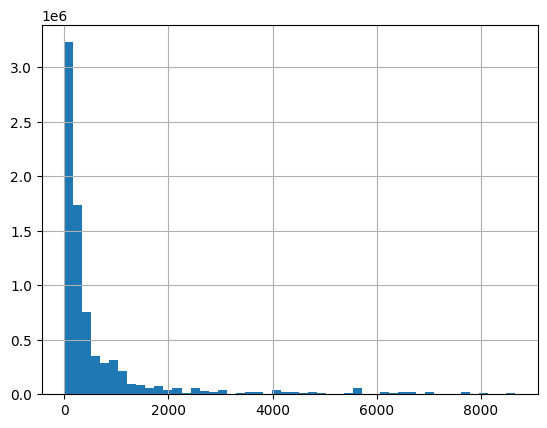

In [43]:
df.covid_cases.hist(bins=50)

In [44]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [45]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  5.0


We could add also information about in which dates the people where closed into their homes.

In [46]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [47]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [48]:
index_non_confinment = df[
    (df['date'] < confinment_date_start) |
    (df['date'] > confinment_date_end)
].index

In [49]:
df.loc[index_non_confinment, 'confinment'] = 0
df['confinment'] = df['confinment'].fillna(1)
df['confinment'] = df['confinment'].astype('int')

### Barcelona Events

In [50]:
os.makedirs('./events', exist_ok=True)

In [51]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [52]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [53]:
events_df.head()

,register_id,prefix,suffix,name,created,modified,status,status_name,core_type,core_type_name,body,tickets_data,addresses,entity_types_data,attribute_categories,values,from_relationships,to_relationships,classifications_data,secondary_filters_data,timetable,image_data,gallery_data,warnings,geo_epgs_25831,geo_epgs_23031,geo_epgs_4326,is_section_of_data,sections_data,start_date,end_date,estimated_dates,languages_data,type,type_name,period,period_name,event_status_name,event_status,ical
0,99400629715,None,None,Mercat de Pagès a Vallcarca i els Penitents,2019-06-13T15:01:08+02:00,2023-05-19T10:08:59.023978+02:00,published,Publicat,event,Agenda,"<p>Parades de productes ecològics, de proximit...","[{'id': 3, 'name': 'Lliure'}]","[{'place': 'plaça del metro de Vallcarca', 'di...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': 'Informació d'interès', 'at...","[{'id': 114759, 'value': 'http://www.facebook....",[],[],"[{'id': 2027, 'name': 'Petits mercats ocasiona...","[{'id': 400015, 'name': 'Petits mercats ocasio...","{'id': 27971, 'html': '<table class=""timetable...",None,[],"[{'id': 6991, 'text': '<p>Revisió</p>', 'type'...","{'x': 428555.9788206734, 'y': 4584832.783654237}","{'x': 428650.506964528, 'y': 4585037.344061564}","{'x': 41.411870483560705, 'y': 2.1451632515859...",None,None,2019-10-03T00:00:00+02:00,None,None,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
1,99400622344,Campanya Vacances Estiu 2023,None,Casal esportiu 'Parkour i acrobàcies' per a in...,2019-03-13T09:45:46+01:00,2023-04-28T11:31:05.717773+02:00,published,Publicat,event,Agenda,<p>Campus de parkour i acrobàcies.</p><p>Insta...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': 'Informació d'interès', 'at...","[{'id': 114449, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2074000, 'name': 'Casals esportius', '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27304, 'html': '<table class=""timetable...",None,[],"[{'id': 12778, 'text': '<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",None,None,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,None,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
2,99400622349,Campanya Vacances Estiu 2023,None,Casal/Campus Esportiu 'Futbol Sala' per a infa...,2019-03-13T09:54:13+01:00,2023-04-28T11:30:57.736367+02:00,published,Publicat,event,Agenda,<p>CAMPUS DE TECNIFICACIÓ FUTBOL SALA Instal·l...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': 'Informació d'interès', 'at...","[{'id': 113819, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2000, 'name': 'Campus', 'full_path': '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27305, 'html': '<table class=""timetable...",None,[],"[{'id': 12668, 'text': '<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",None,None,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,None,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
3,99400076147,None,None,Exposició d'art contemporani,2004-03-09T12:49:22+01:00,2022-09-17T06:13:07.492957+02:00,published,Publicat,event,Agenda,<p>Aquest museu té un fons artístic de més de ...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': None, 'district_name': 'Sants-Montj...","[{'id': 101, 'name': 'agend

In [54]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [55]:
def events_df_drop_columns(
    events_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
        'core_type', 'core_type_name',                                                                 # most is only one type of value
        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
    ]
):
    
    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [56]:
# Drop columns not wanted
events_df = events_df_drop_columns(events_df)

In [57]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [58]:
events_df.head()

,geo_epgs_4326,start_date,end_date
0,"{'x': 41.411870483560705, 'y': 2.1451632515859...",2019-10-03T00:00:00+02:00,None
1,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
2,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
4,"{'x': 41.42214155134015, 'y': 2.1658503000743763}",2023-07-17T03:00:00+02:00,2023-07-28T03:00:00+02:00
5,"{'x': 41.37192068979768, 'y': 2.1701826605872294}",2009-10-01T00:00:00+02:00,None


In [59]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [65]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(str(x)))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [61]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [ ]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

In [ ]:
# Filter out by maximum and minimum dates of df
df_min_date, df_max_date = df.date.min(), df.date.max()

events_df = events_df[events_df.start_date > df_min_date]
events_df = events_df[events_df.end_date < df_max_date]

In [ ]:
print(events_df.shape)
events_df.head()

In [ ]:
sns.jointplot(x="x", y="y", data=events_df, alpha=0.2)

In [ ]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [ ]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [ ]:
print(df_common_events.shape)
df_common_events.head()

In [ ]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin(range_dates)]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)
    

In [ ]:
df.has_event = df.has_event.fillna(0)

In [ ]:
df.head()

In [ ]:
df.columns.values

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [ ]:
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity',                                           # station info
    'year', 'month', 'day', 'hour', 'date_time', 'date',                                      # time info
    'traffic', 'covid_cases', 'confinment', 'has_event',                                      # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
]

selected_df = df[selected_columns_df]

In [ ]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

## Data Engineering

Engineer new variables from the information that we already have. 

In [ ]:
selected_df.date_time = pd.to_datetime(selected_df.date_time)

### Time

In [ ]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [ ]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [ ]:
selected_df['day_info'] = selected_df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [ ]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [ ]:
selected_df['hour_info'] = selected_df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [ ]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [ ]:
selected_df['month_info'] = selected_df.date_time.apply(lambda x: get_month_info(x))

In [ ]:
selected_df.head()

### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [ ]:
selected_df = selected_df.sort_values(['station_id', 'date_time'], ascending=True)

In [ ]:
df_shifted = pd.DataFrame()

In [ ]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)

In [ ]:
df_shifted.head()

### Train / Val / Test Split

In [ ]:
df_shifted.head()

In [ ]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [ ]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

In [ ]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

### Exploration